# <h1><span style="color: orange">1. Introduction to Dimensionality Reduction</span>
</h1>

Dimensionality reduction is a common technique in data analysis and machine learning, used to transform high-dimensional data into a lower-dimensional form while preserving important features. This process is essential for several reasons:

1. Visualization: Human perception is limited to 3 dimensions. Reducing high-dimensional data to 2D or 3D allows us to visualize and interpret complex datasets.

2. Curse of Dimensionality: As the number of dimensions increases, the amount of data needed to generalize accurately grows exponentially. Dimensionality reduction helps mitigate this problem.

3. Computational Efficiency: Lower-dimensional data requires less computational resources for processing and analysis.

4. Noise Reduction: By focusing on the most important features, dimensionality reduction can help filter out noise in the data.

5. Feature Selection: It can help identify the most relevant features in a dataset.

In this tutorial, we'll explore several dimensionality reduction techniques:

- PCA (Principal Component Analysis): A linear technique that finds the directions of maximum variance in the data.
- t-SNE (t-Distributed Stochastic Neighbor Embedding): A non-linear technique that's particularly good at preserving local structure in the data.
- PHATE (Potential of Heat-diffusion for Affinity-based Trajectory Embedding): A more recent technique designed to preserve both local and global structure, particularly useful for biological data.

There are many other techniques available, but starting with PCA is often a good idea. Some toolboxes are now specifically designed to handle together neural activity and imaging data (see Cebra for example https://cebra.ai/)

We'll apply these techniques to a dataset of neural activity and compare their results.



## <h2><span style="color: orange">1.1 Standard imports and helper functions</span></h2>

This defines a few generic functions we'll need further down.

The `if __name__ == "__main__":` line is used to ensure that certain code only runs when the notebook is executed directly, rather than when it is imported as a module in another script. This allows us to run the notebook's functions from another script if needed.

%matplotlib notebook magic command enables interactive plots within the Jupyter notebook. When you use %matplotlib notebook, the plots are rendered with interactive features such as zooming and panning. This can be particularly useful for exploring data visually in a more dynamic way.
%matplotlib inline renders static plots directly within the notebook. When you use %matplotlib inline, the plots are displayed as static images below the code cells that generate them. This is useful for creating quick visualizations that don't require interactivity and is often used for generating plots for reports or documentation.
%matplotlib widget enables interactive plots using the ipywidgets framework. This command provides more advanced interactivity compared to %matplotlib notebook, such as better integration with Jupyter widgets. It is particularly useful for creating complex interactive visualizations.

Compatibility with Jupyter Notebook Versions
- **%matplotlib notebook**: Works with Jupyter Notebook 6.
- **%matplotlib inline**: Works with both Jupyter Notebook 6 and 7.
- **%matplotlib widget**: Works with Jupyter Notebook 7 and requires the `ipympl` package.

> Nerds corner: there are some overkill pythonic syntax tricks you can read about if you are interested. These are additional setting added to the function definition that can help constraint the data types of the inputs and outputs of functions. These are not necessary, but if you do not understand a function delcaration etc... look into it and you will learn useful tricks.

In [ ]:
# Magic command used in Jupyter Notebooks to configure the Matplotlib library for interactive plotting. Uses the ipympl backend.
# %matplotlib inline # Uncomment this line and comment the other to use the standard Matplotlib backend instead



import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
import numpy as np

import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt

plt.ioff()  # Turn off interactive mode


# Seaborn theme with classic/old-fashioned serif fonts and sensible sizing
sns.set_theme(
    context="notebook",
    style="whitegrid",
    palette="colorblind",
    font="serif",
    font_scale=1.1,
)

# Matplotlib rcParams for consistent aesthetics across the full notebook
mpl.rcParams.update({
    # Figure
    "figure.figsize": (8, 5),
    "figure.dpi": 110,
    "figure.constrained_layout.use": True,
    # Fonts (fallbacks if primary not installed)
    "font.family": "serif",
    "font.serif": ["Georgia", "Times New Roman", "Palatino Linotype", "Palatino", "DejaVu Serif", "Times"],
    "mathtext.fontset": "stix",
    # Plot title
    "figure.titlesize": 18,
    # plot.plot specs
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("hsv")),
    "axes.titlesize": 16,
    "axes.titleweight": "regular",
    "axes.titlepad": 8.0,
    "axes.labelsize": 13,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "lines.markersize": 3.0,
    "axes.grid": False,
    # Ticks
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.top": False,
    "ytick.right": False,
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    "xtick.minor.width": 0.6,
    "ytick.minor.width": 0.6,
    # Legend
    "legend.fontsize": 11,
    "legend.frameon": False,
    "legend.loc": "best",
    "legend.handlelength": 2.0,
    "legend.handletextpad": 0.5,
    "legend.borderaxespad": 0.5,
    # Spines
    "axes.spines.top": False,
    "axes.spines.right": False,
    # Errorbar
    "errorbar.capsize": 3.0,
    # Saving
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05,
})

# Optional: subtle grid look
mpl.rcParams["grid.color"] = "#e6e6e6"
mpl.rcParams["grid.linestyle"] = "-"
mpl.rcParams["grid.linewidth"] = 0.5

# Backend choice is set later; style settings are backend-agnostic.
print("Global plotting style applied (serif + seaborn theme)")

In [ ]:
from typing import Optional, Tuple, Union
from scipy.signal import convolve
from scipy.signal import find_peaks


def smooth_data(data: np.ndarray, width: float, fs: float) -> np.ndarray:
    """
    Smooths the input data using a Gaussian kernel.
    
    Parameters:
        data (np.ndarray): Input data to be smoothed.
        width (float): Width of the Gaussian kernel.
        fs (float): Sampling frequency.
        
    Returns:
        np.ndarray: Smoothed data.
    """
    window_size = int(round(width * fs * 2))  # Kernel width in samples, doubling for one-sided
    t = np.linspace(-window_size // 2, window_size // 2, window_size)
    kernel = np.exp(-0.5 * (t / width) ** 2)  # Gaussian kernel
    kernel = kernel / np.sum(kernel)  # Normalize

    # Initialize an array to store the smoothed data
    smoothed_data = np.zeros_like(data)

    # Check if data is 1D or 2D and apply smoothing
    if len(data.shape) == 1:
        smoothed_data = convolve(data, kernel, mode='same')
    else:
        for i in range(data.shape[0]):
            smoothed_data[i, :] = convolve(data[i, :], kernel, mode='same')

    return smoothed_data


def scatter3d(Y: np.ndarray, c: Optional[Union[np.ndarray, str]] = None, figsize: Optional[Tuple[int, int]] = None,
              cmap: str = "Spectral", ticks: bool = False, label_prefix: str = "", ax: Optional[Axes] = None) -> None:
    """
    
    Parameters:
        Y (np.ndarray): Coordinates for scatter plot, shape (n_samples, 3).
        c (Optional[Union[np.ndarray, str]]): Color labels for each sample.
        figsize (Optional[Tuple[int, int]]): Size of the figure.
        cmap (str): Colormap to be used.
        ticks (bool): Whether to display ticks.
        label_prefix (str): Prefix for axis labels.
        ax (Optional[Axes]): Axis to plot on, if None, a new figure and axis are created.
        
    Returns:
        None
    """
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=c, cmap=cmap)

    ax.set_xlabel(f"{label_prefix}1")
    ax.set_ylabel(f"{label_prefix}2")
    ax.set_zlabel(f"{label_prefix}3")

    if not ticks:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    plt.colorbar(sc, ax=ax)

if __name__ == "__main__":
    # matplotlib settings for Jupyter notebooks only
    #%matplotlib notebook
    %matplotlib widget
    # %matplotlib inline # Uncomment this line and comment the other to use the standard Matplotlib backend instead

## <h2><span style="color: orange">1.2 Load dataset</h2></span>

We expect in the matlab dataset the following fields:

behaviour (1 x T)
result  (N x T)
tax (1 x T)
(optionally) coords (N x 3)

All samples are N x T, with T in dim 2.

The data is expected to be in the same folder as the script, or you will have to change the path. If you export data from MATLAB to Python, make sure data is saved with the '-v7' format and not '-v7.3'. Here are two examples where we import variables that were either inserted directly in the mat file, or stored in a dictionary.


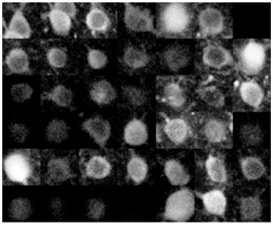

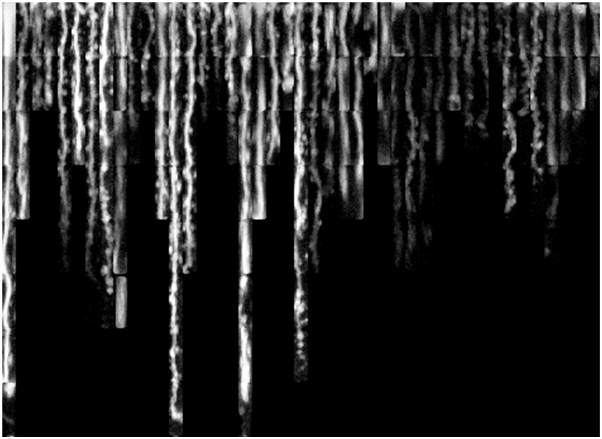

In [ ]:
from scipy.io import loadmat

# Selector for choosing the dataset
dataset_choice = "population"  # Change to "dendrites" to use the other dataset

if dataset_choice == "dendrites":
    # Load the .mat file for the tree dataset. these were variables directly stored in the .mat file
    mat_path = "Data/M1_dendritic_tree_data.mat"  # Update this path to the location of your .mat file
    mat_data = loadmat(mat_path)
    
    # Extract the variables
    behaviour = mat_data['behaviour'].squeeze()  # Squeeze to remove single-dimensional entries
    result = mat_data['result']
    tax = np.squeeze(mat_data['tax'].T)
    coords = mat_data['coords']

elif dataset_choice == "population":
    # Load the .mat file for the M1 dataset. # these were variables stored in a structure in the .mat file
    mat_path = "Data/M1_population_data.mat"  # Data exported from matlab
    mat_data = loadmat(mat_path)
    
    # Extract the variables
    mat_data = mat_data['mat_data']
    behaviour = mat_data['behaviour'][0, 0].squeeze()  # Indexing to access the nested structure and squeeze to remove single-dimensional entries
    result = mat_data['result'][0, 0]  # Indexing to access the nested structure
    tax = mat_data['tax'][0, 0].squeeze()  # Indexing to access the nested structure and squeeze to remove single-dimensional entries

# Get the dimensions
T, N = len(behaviour), result.shape[0]

# Ensure result shape is (Individuals, Timepoints)
print(result.shape) # N x T
print(tax.shape) # T x 1
print(behaviour.shape) # T x 1 

In [ ]:
original_result = result # we keep a backup of the original data for final plotting
original_behaviour = behaviour

## <h2><span style="color: orange">1.3 Smooth and plot data</h2></span>

In [ ]:
# Initialize smoothed arrays
sm_result = original_result
sm_behaviour = original_behaviour

# Build smoothing kernel
width = 1.0  # Standard deviation in seconds
fs = 1 / np.median(np.diff(tax))  # Sampling frequency based on 'tax'

# Smoothing the result and behaviour arrays
sm_result = smooth_data(original_result, width, fs)
sm_behaviour = smooth_data(original_behaviour, width, fs)

# Safeguard backups to prevent double-smoothing side-effects on re-runs
# Initialize once; keep existing backups if already defined
try:
    sm_behaviour_bkp
except NameError:
    sm_behaviour_bkp = sm_behaviour.copy()

try:
    sm_result_bkp
except NameError:
    sm_result_bkp = sm_result.copy()

### Shared plotting helpers
The `plot_waterfall` and `plot_heatmap` functions below are mirrored in the linear regression lecture to ensure consistent figure styling across notebooks.

In [ ]:
def plot_waterfall(data: np.ndarray,
                   time_axis: np.ndarray,
                   behaviour: Optional[np.ndarray] = None,
                   title: str = 'Plot of Smoothed Neural Data') -> None:
    """Plot the smoothed result using a waterfall plot.

    Parameters:
        data (np.ndarray): The data to plot.
        time_axis (np.ndarray): The time axis for the data.
        behaviour (Optional[np.ndarray]): Optional behaviour data to plot as a red trace.
        title (str): The title of the plot.
    """
    fig, ax = plt.subplots()

    # Compute the spacing based on the max range of the data
    max_range = np.max(data) - np.min(data)
    spacing = max_range * 0.1

    for i in range(data.shape[0]):  # Plot all traces
        ax.plot(time_axis, data[i, :] + i * spacing, color='black')

    # Clip X axis to data range
    ax.set_xlim([time_axis[0], time_axis[-1]])

    if behaviour is not None:
        # Normalize behaviour data to fit within the plot
        norm_behaviour = (behaviour - np.min(behaviour)) / (np.max(behaviour) - np.min(behaviour)) * max_range
        ax.plot(time_axis, norm_behaviour + data.shape[0] * spacing, color='red')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

def plot_heatmap(data: np.ndarray,
                 time_axis: np.ndarray,
                 behaviour: Optional[np.ndarray] = None,
                 title: str = 'Heatmap of Smoothed, RAW Neural Data',
                 clim: Optional[Tuple[float, float]] = None) -> None:
    """Plot the smoothed result using imshow in black and white.

    Parameters:
        data (np.ndarray): The data to plot.
        time_axis (np.ndarray): The time axis for the data.
        behaviour (Optional[np.ndarray]): Optional behaviour data to plot as a red trace.
        title (str): The title of the plot.
    """
    fig, (ax_behaviour, ax) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 7]}, sharex=True)

    # Plot behaviour data above the heatmap
    if behaviour is not None:
        ax_behaviour.plot(time_axis, behaviour, color='red')
        ax_behaviour.axis('off')
        ax_behaviour.set_xlim([time_axis[0], time_axis[-1]])

    # Compute the color axis limits based on the data range
    vmin, vmax = np.min(data), np.max(data)

    cax = ax.imshow(data, aspect='auto', cmap='gray_r', interpolation='none',
                    vmin=vmin, vmax=vmax,
                    extent=[time_axis[0], time_axis[-1], 0, data.shape[0]])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neuron Index')
    ax.set_title(title)

    fig.colorbar(cax, ax=ax, orientation='horizontal', label='Amplitude')

    # Adjust the position of the behavior plot to align with the heatmap
    pos1 = ax.get_position()
    pos2 = [pos1.x0, pos1.y0 + pos1.height + 0.05, pos1.width, pos1.height * 0.1]
    ax_behaviour.set_position(pos2)

    # Clip X axis to data range
    ax.set_xlim([time_axis[0], time_axis[-1]])

    # apply color limits if provided
    if clim is not None:
        cax.set_clim(clim)

    plt.show()


In [ ]:
# Plot the smoothed data using both visualization methods
plot_waterfall(sm_result, tax)
plot_heatmap(sm_result, tax, sm_behaviour, clim=(-0.5, 3.0))


## <h2><span style="color: orange">1.4 Filter NaN Values</h2></span>

When performing PCA and clustering on neural data, handling NaN (Not a Number) values is required. NaN values can arise from various sources, such as missing data, artifacts, or preprocessing steps.

Most techniques like PCA require a complete dataset without NaN values. NaNs can disrupt the calculation of covariance matrices and eigenvectors, leading to incorrect or undefined principal components. Clustering algorithms, such as K-means or hierarchical clustering, rely on distance metrics to group similar data points. NaNs can distort these distance calculations, leading to incorrect cluster assignments or more often failed function execution.

**Datapoint removal:**
You usually have to remove individuals that have only or too many NaNs. If you do it, don't forget to keep track of the original identity of each row as you may need it later on (if you remove row 5 which used to code for neuron #5, then row 5 later corresponds to neuron #6 etc...).
You may also need to remove timepoints that have a NaN in at least one of the neurons. Note that this can distort the temporal structure of the data. Important temporal patterns might be lost if many timepoints are removed. Also, don't forget to remove these timepoints on all other aligned variables, such as your behaviour variable.

**Interpolation:**
This preserves the entire dataset by estimating missing values based on surrounding data points. It maintains the temporal structure and continuity of the data but introduces assumptions. Some interpolation techniques can create values that fall outside the range of the known data points, while others stay within this range. For neural data where spiky responses are problematic, linear interpolation and PCHIP are safest, as they stay within the data range. Methods like Makima, cubic spline, and quadratic interpolation are not recommended due to their potential to generate out-of-range or spiky responses.
There are other methods, and you should always consider this criterion when choosing them. Also, make sure the trace edges are handled properly without creating transients when there are NaNs at the beginning or end of the trace.

In [ ]:
# Define the maximum number of tolerable NaNs per row
max_tolerable_nans = 1

# Create a boolean mask for rows (individuals) that have more than the maximum tolerable NaNsaximum tolerable NaNsaximum tolerable NaNs
bad_individual_mask = np.sum(np.isnan(sm_result), axis=1) > max_tolerable_nans

# Find the indices of the bad individuals the bad individuals the bad individuals
bad_individual_idx = np.where(bad_individual_mask)[0]

# Remove the bad individuals from the result array
sm_result = np.delete(sm_result, bad_individual_idx, axis=0)

# Create a boolean mask for timepoints that have at least one NaN in the remaining dataona NaN in th avemainingldettone NaN in the remaining data
bad_tp_mask = np.any(np.isnan(sm_result), axis=0)

# Find the indices of the bad individuals the bad individuals the bad individuals
bad_tp_idx = np.where(bad_tp_mask)[0]

# Update the behaviour array to remove bad timepoints
sm_behaviour = np.delete(sm_behaviour, bad_tp_idx)
sm_result = np.delete(sm_result, bad_tp_idx, axis=1)

#plot_waterfall(sm_result, tax)
#plot_heatmap(sm_result, tax, sm_behaviour)

## <h2><span style="color: orange">1.5 Dataset subselection</h2></span>

We do not have to use the full dataset. For example, we could focus just on the timepoints where neurons were active, or where the network had enough activity. This can speed up the analysis, but it can also bias the data.

In [ ]:
print(sm_result)

use_peaks = 0  # Set this to 0, 1, or 2 based on desired method. I recommend 0 for the M1 pop dataset, and 2 for the tree dataset

# Control flags for method 1
prominence_factor = 1  # A: Prominence factor
compute_globally = False  # B: Compute prominence globally or locally
compute_on_mean = False  # C: Compute peaks on the mean or on each row

if use_peaks == 1:
    # Method 1: Detect peaks in the data
    detected_peaks = []
    row_peaks = []

    if compute_on_mean:
        # Compute peaks on the mean of the data
        mean_row = np.mean(sm_result, axis=0)
        prominence_value = np.ptp(mean_row) * prominence_factor
        peaks, _ = find_peaks(mean_row, prominence=prominence_value, distance=20, width=20)
        detected_peaks.extend(peaks)
    else:
        # Compute peaks on each row
        for row in sm_result:
            prominence_value = np.std(row) * prominence_factor
            peaks, _ = find_peaks(row, prominence=prominence_value, distance=20, width=20)
            row_peaks.append(peaks)
            detected_peaks.extend(peaks)
    
    # Removing duplicate peaks and sorting them
    peak_t = sorted(set(detected_peaks))
    result = sm_result[:, peak_t]
    behaviour = sm_behaviour[peak_t]

elif use_peaks == 2:
    # Method 2: Use pre-defined event times, if you have event_t in the initial import
    peak_t = mat_data['event_t'].T.squeeze()
    result = sm_result[:, peak_t]
    behaviour = sm_behaviour_bkp[peak_t]

else:
    # Method 0: Use all timepoints
    peak_t = np.arange(sm_result.shape[1])  # All timepoints
    result = sm_result
    behaviour = sm_behaviour_bkp

# Plotting the original data and detected peaks
plt.figure()

# Compute the spacing based on the max range of the data
max_range = np.max(sm_result) - np.min(sm_result)
spacing = max_range * 0.1

# Plot the first 10 traces with offsets
for i in range(min(10, sm_result.shape[0])): 
    plt.plot(sm_result[i, :] + i * spacing, label=f'Trace {i + 1}')  # Plotting original data with offset
    if use_peaks == 1 and not compute_on_mean:
        plt.scatter(row_peaks[i], sm_result[i, row_peaks[i]] + i * spacing, color='red')  # Plotting detected peaks for each row

print(sm_result)
plt.title("Traces with Detected Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude + Offset")
plt.show()

if use_peaks:
    # Raster plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [4, 1]})

    # Plotting the raster plot
    for i in range(sm_result_bkp.shape[0]):
        if use_peaks == 1 and not compute_on_mean:
            ax1.eventplot(row_peaks[i], lineoffsets=i, colors='black')
        else:
            ax1.eventplot(peak_t, lineoffsets=i, colors='black')

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Neuron Index')
    ax1.set_title('Raster Plot of Detected Peaks')

    # Plotting the average trace
    if (use_peaks == 1 and compute_globally) or use_peaks == 2:
        mean_trace = np.mean(sm_result_bkp, axis=0)
        ax2.plot(mean_trace, label='Mean Trace', color='blue')
        ax2.scatter(peak_t, mean_trace[peak_t], color='red', label='Detected Peaks')
        ax2.set_title("Mean Trace with Detected Peaks")
        ax2.legend()
    else:
        ax2.set_title("Mean Trace without Detected Peaks")
        ax2.plot(np.mean(sm_result_bkp, axis=0), label='Mean Trace', color='blue')
        

        

    plt.tight_layout()
    plt.show()


## <h2><span style="color: orange">1.6 Normalization</h2></span>

Normalization of neural data is a crucial preprocessing step before applying dimensionality reduction techniques like Principal Component Analysis (PCA) or clustering algorithms. Here's why it's important and what could happen if you skip this step:

### Importance of Normalization

**Focus on Signal Variance**
Z-Score Normalization: A common normalization technique is z-score normalization, which scales the data based on its mean and standard deviation. This ensures that each feature contributes equally to the analysis (each feature unit-variance), preventing features with larger scales from dominating the results.

Here, in the "dendrites" example, we subtract the shared signal (overall median) between all signals instead of doing a Z-scoring ; This is not the common approach, but you can have your own normalization if justified by hypothesis-driven reasons. For example, if you **know** that there is common shared mode/component in your dataset (maybe your neurons are coupled by gap junctions. Maybe data come from multiple compartments of a single neuron, and you want to take out the neuron global activity). By removing the median from all traces, you center the data around zero. This helps in focusing on the fluctuations in the signal rather than the absolute values. This is particularly useful in neural data where the interest often lies in the relative changes rather than the baseline activity. But as asaid above, be careful with custom apporaches as it can suppress real signal and introduce anticorrelations.

If you plan to do machinelearning : Fit normalization on train only; apply to test to prevent temporal leakage.

**Improved Algorithm Performance:**
PCA: PCA aims to find the directions (principal components) that maximize the variance in the data. If the data is not normalized, features with larger scales can disproportionately influence the principal components, leading to misleading results.

**Clustering:**
Clustering algorithms like K-means rely on distance metrics to group similar data points. Without normalization, features with larger scales can skew the distance calculations, resulting in poor clustering performance.

**Comparability:**
Normalization makes the data from different sources or experiments comparable. This is essential in neural data analysis where recordings might come from different sessions or subjects.

**Consequences of Skipping Normalization**
The results of dimensionality reduction and clustering might be harder to interpret if the data is not normalized. For example, the principal components might not correspond to meaningful patterns in the data.

**Example:**
Consider a dataset with two features: neural firing rate (measured in Hz) and stimulus intensity (measured in arbitrary units). If the firing rate ranges from 0 to 100 Hz and the stimulus intensity ranges from 0 to 1, the PCA might primarily capture the variance in the firing rate, ignoring the stimulus intensity. Normalizing both features ensures that PCA considers both features equally.

In [ ]:
from scipy.stats import zscore

# Normalize the data (neurons x timepoints) before PCA/clustering
if dataset_choice == "dendrites":
    norm_result = sm_result - np.nanmedian(sm_result, axis=0)
elif dataset_choice == "population":    
    norm_result = zscore(sm_result, axis=0)

## We reuse the plotting function we setup earlier on
plot_waterfall(norm_result, tax)
plot_heatmap(norm_result, tax)

# <h1><span style="color: orange">2 Correlation matrix</h1></span>

Correlation matrices enable analyzing relationships between multiple variables, particularly in the context of neural activity patterns. These matrices can help measure how different neurons or brain regions interact with each other, helping uncover functional connections and patterns of co-activation.

At its core, a correlation matrix is a square table where each cell represents the correlation coefficient between two variables. In neuroscience, these variables are often the activity patterns of individual neurons or specific brain areas. The correlation coefficient, typically Pearson's r (but you may want to consider Spearman, a nonlinear alternative), ranges from -1 to 1, indicating the strength and direction of the linear relationship between each pair of variables.

Interpreting a correlation matrix involves looking at both the magnitude and sign of the correlations:

- A positive correlation (closer to 1) indicates that as one variable increases, the other tends to increase as well.
- A negative correlation (closer to -1) suggests an inverse relationship: as one variable increases, the other tends to decrease.
- Values close to 0 indicate little to no linear relationship between the variables.

By computing correlations over different time windows, it can also be possible to study how neural relationships evolve over time.

Remember that correlation does not imply causation. Strong correlations between neural activities don't necessarily mean direct connections or causal relationships. Additionally, correlation matrices only capture linear relationships and may miss more complex, non-linear interactions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

def plot_correlation_matrix(data, sorted=False, color_threshold=0.9, optimize=False, distance_method='correlation'):
    """
    Plot correlation matrix with optional clustering.
    
    Parameters:
    -----------
    data : array-like, shape (n_series, n_time)
    sorted : bool, whether to sort by hierarchical clustering
    color_threshold : float, threshold for dendrogram coloring
    optimize : bool, whether to optimize number of clusters
    distance_method : str, either 'correlation' or 'euclidean'
        - 'correlation': uses correlation distance + average linkage (better for Ca2+)
        - 'euclidean': uses euclidean distance + ward linkage (standardized data)
    """
    # Validate input
    data = np.asarray(data)
    if data.ndim != 2:
        raise ValueError(f"data must be 2D (n_series x n_time), got shape {data.shape}")
    if not np.isfinite(data).all():
        raise ValueError("data contains NaN/inf; clean or interpolate before computing correlations")

    # Compute the correlation matrix (always preserve this)
    corr_matrix = np.corrcoef(data)
    
    if sorted:
        # Choose distance method and prepare data accordingly
        if distance_method == 'correlation':
            # Option 1: Correlation distance + Average linkage (better for Ca2+)
            distance_metric = 'correlation'
            linkage_method = 'average'  # Compatible with correlation distance
            data_for_clustering = data  # Use raw data
            max_clusters_default = 20  # Reduced for fewer clusters
            
        elif distance_method == 'euclidean':
            # Option 2: Euclidean distance + Ward linkage (standardized data)
            distance_metric = 'euclidean'  # Fixed spelling
            linkage_method = 'ward'
            # Standardize data for euclidean distance
            data_for_clustering = StandardScaler().fit_transform(data.T).T
            max_clusters_default = 15  # Reduced for fewer clusters
            
        else:
            raise ValueError(f"distance_method must be 'correlation' or 'euclidean', got '{distance_method}'")

        # Compute pairwise distances and linkage matrix
        dist_matrix = pdist(data_for_clustering, metric=distance_metric)
        linkage_matrix = linkage(dist_matrix, method=linkage_method, optimal_ordering=sorted)

        # If optimize is true, find the optimal number of clusters
        if optimize:
            optimal_clusters, _ = optimize_clusters(data_for_clustering, linkage_matrix, 
                                                  distance_metric=distance_metric, 
                                                  max_clusters=max_clusters_default)
            print(f"Optimal number of clusters: {optimal_clusters}")

            # Use maxclust criterion for more stable results
            cluster_assignments = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')
            
            # Get the color threshold for dendrogram plotting
            if optimal_clusters > 1:
                color_threshold = linkage_matrix[-(optimal_clusters-1), 2]
            else:
                color_threshold = 0
            print(f"Corresponding color threshold: {color_threshold}")
        else:
            optimal_clusters = None

        # Plot dendrogram and get its data
        plt.figure(layout='tight')
        above_threshold_color = 'black'
        dendro = dendrogram(linkage_matrix, color_threshold=color_threshold, above_threshold_color=above_threshold_color)
        plt.title(f"Dendrogram ({distance_method} distance)")
        plt.show()

        # Extract order from dendrogram
        order = dendro['leaves']

        # Assign cluster labels to each data point
        if optimize:
            group_labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')
        else:
            group_labels = fcluster(linkage_matrix, color_threshold, criterion='distance')

        # Reorder the correlation matrix and group labels
        corr_matrix = corr_matrix[order][:, order]
        group_labels = group_labels[order]
        cluster_boundaries = np.where(np.diff(group_labels) != 0)[0]
    else:
        order = None
        group_labels = None
        cluster_boundaries = []
    
    # Plot the correlation matrix
    plt.figure(layout='tight')
    im = plt.matshow(corr_matrix, cmap='seismic', vmin=-1, vmax=1)
    plt.colorbar(im, label='Correlation')
    plt.title(f"{'Sorted ' if sorted else ''}Correlation Matrix")
    
    if sorted and len(cluster_boundaries) > 0:
        # Add lines to separate clusters
        for boundary in cluster_boundaries:
            plt.axhline(y=boundary + 0.5, color='black', linestyle='--', linewidth=0.5)
            plt.axvline(x=boundary + 0.5, color='black', linestyle='--', linewidth=0.5)
    
    plt.show()

    return corr_matrix, order, group_labels

def optimize_clusters(data, linkage_matrix, max_clusters=10, distance_metric='correlation'):
    # Safety: ensure reasonable ranges
    max_clusters = int(max(2, max_clusters))
    scores = []
    optimization_method = 'silhouette_score'
    for n_clusters in range(2, max_clusters + 1):
        print(f"Computing silhouette score for {n_clusters} clusters...")
        cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
        if optimization_method == 'silhouette_score':
            score = silhouette_score(data, cluster_labels, metric=distance_metric)
        elif optimization_method == 'davies_bouldin_score':
            score = davies_bouldin_score(data, cluster_labels)
        scores.append(score)
    
    # plot the silhouette scores and indicate the maximum
    plt.figure(layout='tight')
    plt.plot(range(2, max_clusters + 1), scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    plt.show()

    optimal_clusters = np.argmax(scores) + 2  # +2 because we started from 2 clusters
    return optimal_clusters, scores

# Example usage:
# Option 1: Correlation distance (recommended for Ca2+ analysis)
# corr_matrix, corr_order_matrix, corr_group_labels = plot_correlation_matrix(norm_result, sorted=True, optimize=True, distance_method='correlation')

# Option 2: Euclidean distance (standardized data)
corr_matrix, corr_order_matrix, corr_group_labels = plot_correlation_matrix(norm_result, sorted=True, optimize=True, distance_method='euclidean')

# example with a fixed threshold
# corr_matrix, corr_order_matrix, corr_group_labels = plot_correlation_matrix(norm_result, sorted=True, color_threshold=0.9)

In [ ]:
def display_group_averages(result, labels):
    """
    Display the average of each group given the result matrix and labels.

    Parameters:
    - result: numpy array, shape (N, T)
        The input data matrix where N is the number of neurons and T is the number of timepoints.
    - labels: numpy array, shape (N,)
        The labels indicating the group of each neuron.

    Returns:
    None
    """
    # Convert labels to integers if they are not already
    if isinstance(labels[0], str):
        labels = np.array([int(label) for label in labels])

    unique_labels = np.unique(labels)
    std_devs = []  # To store the standard deviation of each mean trace

    plt.figure()

    for label in unique_labels:
        if label == -1:
            # Skip the noise cluster
            continue

        # Get the indices for neurons in this cluster
        cluster_indices = np.where(labels == label)[0]

        # Subset the data for this cluster
        cluster_data = result[cluster_indices, :]

        # Calculate the mean trace for this cluster
        mean_trace = np.nanmean(cluster_data, axis=0)
        
        # Store the standard deviation of the mean trace
        std_devs.append(np.std(mean_trace))

    # Compute the optimal offset as the maximum standard deviation
    optimal_offset = max(std_devs)

    offset = 0  # Initialize an offset for the vertical translation
    for label in unique_labels:
        if label == -1:
            continue
        cluster_indices = np.where(labels == label)[0]
        cluster_data = result[cluster_indices, :]
        mean_trace = np.nanmean(cluster_data, axis=0)
        plt.plot(mean_trace + offset, label=f'Cluster {label+1}', lw=0.5)
        offset += optimal_offset * 2

    plt.title("Mean Traces for Each Cluster")
    plt.xlabel("Time")
    plt.ylabel("Mean Signal")
    plt.show()

print(corr_group_labels)
display_group_averages(norm_result, corr_group_labels)

In [ ]:
def plot_cluster_sorted_signals(data_matrix, labels, plot_title, order=None):
    """
    Plots the signals in an image, sorted according to their cluster assignment.
    
    Parameters:
    - data_matrix: numpy array, shape (N, T)
        Time series of calcium imaging from N neurons.
    - labels: numpy array, shape (N, )
        Cluster indices assigned by your clustering function.
    - plot_title: str
        Title for the plot.
    """
    
    # Z-score each row
    zscored_data = (data_matrix - np.nanmean(data_matrix, axis=1, keepdims=True)) / np.nanstd(data_matrix, axis=1, keepdims=True)
    
    # Subtract the baseline (10th percentile) from each row
    baseline_subtracted_data = zscored_data - np.nanpercentile(zscored_data, 10, axis=1, keepdims=True)
    
    # Sort the data_matrix based on the cluster labels
    # if order was provided, use it, otherwise compute based on labels
    if order is not None:
        sorted_data = baseline_subtracted_data[order, :]
    else:
        order = np.argsort(labels)
        sorted_data = baseline_subtracted_data[order, :]
    
    plt.figure()
    plt.imshow(sorted_data, aspect='auto', cmap='gray_r')
    plt.colorbar()
    plt.clim(0, np.nanpercentile(sorted_data, 95))  # Scale colorscale between 0 and 50th percentile
    plt.title(plot_title)
    plt.xlabel("Time")
    plt.ylabel("Cluster")
    
    # Add red dotted lines to separate clusters
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_boundaries = np.cumsum(counts)[:-1]
    for boundary in cluster_boundaries:
        plt.axhline(y=boundary, color='red', linestyle='--', linewidth=1)
    
    plt.show()

plot_cluster_sorted_signals(norm_result, corr_group_labels, "Hierarchical Clustering Sorted Signals", corr_order_matrix)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def kmeans_clustering_with_heatmap(data, hierarchical_group_labels, plot_heatmap=True):
    """
    Perform K-means clustering and create correlation matrix with cluster ordering.
    
    Parameters:
    -----------
    data : array-like, shape (n_series, n_time)
        The original data
    hierarchical_group_labels : array-like
        Cluster labels from previous clustering (used only to get n_clusters)
    plot_heatmap : bool
        Whether to plot the correlation heatmap
    
    Returns:
    --------
    kmeans_labels : array
        K-means cluster labels
    order : array
        Ordering of data points for plotting
    corr_matrix_reordered : array
        Correlation matrix reordered by clusters
    """
    
    if hierarchical_group_labels is None:
        raise ValueError("No previous clustering results found.")
    
    # Get the number of clusters
    n_clusters = len(np.unique(hierarchical_group_labels))
    print(f"Performing K-means clustering with {n_clusters} clusters")
    
    # Standardize data for K-means
    data_standardized = StandardScaler().fit_transform(data.T).T
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(data_standardized)
    
    # Add 1 to labels to match standard numbering (starts from 1)
    kmeans_labels = kmeans_labels + 1
    
    print(f"K-means clustering completed")
    print(f"Cluster sizes:", [np.sum(kmeans_labels == i) for i in np.unique(kmeans_labels)])
    
    # Create order by sorting data points by their cluster labels
    order = np.argsort(kmeans_labels)
    
    # Compute correlation matrix and reorder it
    corr_matrix = np.corrcoef(data)
    corr_matrix_reordered = corr_matrix[order][:, order]
    
    # Get reordered labels and find cluster boundaries
    kmeans_labels_reordered = kmeans_labels[order]
    cluster_boundaries = np.where(np.diff(kmeans_labels_reordered) != 0)[0]
    
    if plot_heatmap:
        # Plot the correlation matrix heatmap
        plt.figure(layout='tight')
        im = plt.matshow(corr_matrix_reordered, cmap='seismic', vmin=-1, vmax=1)
        plt.colorbar(im, label='Correlation')
        plt.title("K-means Sorted Correlation Matrix")
        
        # Add lines to separate clusters
        for boundary in cluster_boundaries:
            plt.axhline(y=boundary + 0.5, color='black', linestyle='--', linewidth=0.5)
            plt.axvline(x=boundary + 0.5, color='black', linestyle='--', linewidth=0.5)
        
        plt.show()
    
    return kmeans_labels, order, corr_matrix_reordered

# Usage:
kmeans_labels, kmeans_order, kmeans_corr_matrix = kmeans_clustering_with_heatmap(norm_result, corr_group_labels)

# Call your plotting function with the K-means results
plot_cluster_sorted_signals(norm_result, kmeans_labels, "K-means Cluster Sorted Signals", kmeans_order)

In [ ]:
# Let's build a sorted matrix with the datapoints where behaviour is > 0, and the data is sorted by the cluster labels
# then do a corr-matrix for the quiet state and sort the matrix using the previously computed labels for the active state
# and then plot the 2 matrices side by side

# Get the indices where the behaviour is greater than 0
active_indices = np.where(behaviour > 0.1)[0]

# Get the data for the active state
active_data = result[:, active_indices]

# Run the correlation matrix for the active state
corr_matrix, corr_order_active, group_labels_active = plot_correlation_matrix(active_data, sorted=True, optimize=True, distance_method='euclidean')

# Get the indices where the behaviour is less than 0.1
inactive_indices = np.where(behaviour < 0.1)[0]

# Get the data for the inactive state
inactive_data = result[:, inactive_indices]

# Run the correlation matrix for the inactive state
corr_matrix, corr_order_inactive, group_labels_inactive = plot_correlation_matrix(inactive_data, sorted=True, optimize=True, distance_method='euclidean')



In [ ]:
use_Rastermap = False

if use_Rastermap:
    from rastermap import Rastermap

    # Assume 'sm_result_bkp' is your preprocessed matrix (neurons x time)
    # Should be z-scored, NaN-free, and ready for Rastermap

    # Core Rastermap parameters
    model = Rastermap(
        n_clusters=0,        # Single-neuron sorting (set to int >0 for clustering)
        n_PCs=12,              # Number of principal components
        time_lag_window=30,    # Time lag window
        locality=0.9,          # Locality parameter
        grid_upsample=0,       # Grid upsampling
        normalize=True,        # Normalize data
        mean_time=True,        # Mean over time
        sticky=True,           # Sticky sorting
        random_state=0         # For reproducibility
    ).fit(sm_result_bkp)

    # Get neuron ordering
    neuron_order_rastermap = model.isort.astype(int)
    sorted_labels = np.arange(len(neuron_order_rastermap))[np.argsort(np.argsort(model.embedding.squeeze()))]

    # Optional cluster labels (if n_clusters > 0), otherwise set to None
    cluster_labels_rastermap = getattr(model, 'embedding_clust', None)

    print(f"Sorted {norm_result.shape[0]} neurons")
    print(f"Neuron order shape: {neuron_order_rastermap.shape}")

    plot_cluster_sorted_signals(norm_result, None, "Cluster Sorted Signals", neuron_order_rastermap)

# <h1><span style="color: orange">3. Dimensionality reduction</h1></span>
    
As neuroscientists, we often work with high-dimensional data. For instance, when recording from 100 neurons simultaneously, we're dealing with 100 dimensions. To analyze and visualize this complex data, we use dimensionality reduction techniques like PCA and t-SNE.

## <h2><span style="color: orange">3.1 Principal Component Analysis (PCA)</h2></span>

PCA identifies the directions of maximum variance in your data.

- It finds orthogonal axes (principal components) that capture the most variation in the dataset.
- These components are ordered by the amount of variance they explain.
- PCA is a linear transformation of the original data.

In neuroscience applications:
- We typically use the top 2-3 components for visualization.
- This can reveal dominant patterns in neural activity across the population.

Example: In motor cortex recordings during reaching tasks, PCA might identify components corresponding to reach direction or velocity.


In [ ]:
import sklearn.decomposition  # For PCA
import sklearn.manifold  # For t-SNE
import time

# PCA: Principal Component Analysis, used for dimensionality reduction.
# It transforms the data to a new coordinate system, maximizing variance along the axes.
start = time.time()
pca_operator = sklearn.decomposition.PCA(n_components=3)  # Creating a PCA object with 3 components
Y_pca = pca_operator.fit_transform(np.array(norm_result))  # Transforming 'result' using PCA
end = time.time()
print(f"Embedded PCA in {end - start:.2f} seconds.")  # Printing the time taken for PCA embedding

# Plotting the 3D PCA with nice labels and appearance
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Using the scatter3d function defined earlier
unique_values, pca_indices = np.unique(corr_group_labels, return_inverse=True)
scatter3d(Y_pca, c=pca_indices, cmap='viridis', ticks=True, label_prefix="PC", ax=ax)

# Setting the title
ax.set_title('3D PCA Plot')

# Display the plot
plt.show()


## <h2><span style="color: orange">3.2 t-SNE in Calcium Imaging Analysis</h2></span>

t-SNE (t-Distributed Stochastic Neighbor Embedding) is an example of a nonlinear dimensionality reduction method (UMAP is a related alternative). When working with calcium imaging data, t-SNE can be used for visualizing complex patterns in neural activity. Unlike PCA, t-SNE is a nonlinear technique that excels at preserving local structure in high-dimensional data. Non-linear methods are often visualization methods, dedicated to sorting out complex relationships.
In the context of calcium imaging, we would typically apply t-SNE to the time series of calcium signals from many neurons. The algorithm arranges neurons in a lower-dimensional space (usually 2D or 3D) based on the similarity of their activity patterns over time. Neurons that show similar activation patterns end up close together in this new space.
However, it's important to be aware of some limitations when using t-SNE for time series data like calcium imaging:

Latent Variable Interpretation: Unlike PCA, t-SNE does not provide easily interpretable latent variables. While PCA components can be directly related back to specific patterns of neural activity over time, t-SNE dimensions don't have a straightforward relationship to the original variables. This means we can't easily reconstruct or interpret specific temporal sequences of neural activity from the t-SNE output.
Temporal Information: Although t-SNE can preserve some temporal structure depending on how the data is prepared, it doesn't explicitly model time. The resulting visualization may not directly show you the sequence of neural events in the same way that the original time series or PCA components would.
Parameter Sensitivity: t-SNE results can be sensitive to parameter choices, particularly the perplexity parameter.
Computational Intensity: t-SNE can be computationally intensive for large datasets, which is often the case in calcium imaging.

In [ ]:
# t-SNE: t-Distributed Stochastic Neighbor Embedding, used for visualizing high-dimensional data.
# Before applying t-SNE, we are performing PCA to reduce the number of dimensions to 100, which can help in speeding up t-SNE.
start = time.time()
pca_operator = sklearn.decomposition.PCA(n_components=100, random_state=42)  # PCA with fixed random_state for reproducibility
tsne_operator = sklearn.manifold.TSNE(n_components=3, perplexity=3, learning_rate=10, random_state=42, init="pca")  # t-SNE with fixed random_state
Y_tsne = tsne_operator.fit_transform(pca_operator.fit_transform(np.array(norm_result)))  # Transforming 'result' using PCA and then t-SNE
end = time.time()
print(f"Embedded t-SNE in {end - start:.2f} seconds.")  # Printing the time taken for t-SNE embedding

# Plotting the 3D t-SNE with nice labels and appearance
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Using the scatter3d function defined earlier
unique_values, indices_tsne = np.unique(corr_group_labels, return_inverse=True)
scatter3d(Y_tsne, c=indices_tsne, cmap='viridis', ticks=True, label_prefix="tSNE", ax=ax)

# Setting the title
ax.set_title('3D t-SNE Plot')

# Display the plot
plt.show()

## <h2><span style="color: orange">3.3 Embedding Data Using PHATE</h2></span>

<b>PHATE</b> (Potential of Heat-diffusion for Affinity-based Trajectory Embedding) is a tool for visualizing high dimensional data. PHATE uses a novel conceptual framework for learning and visualizing the manifold to preserve both local and global distances.

To see how PHATE can be applied to datasets such as facial images and single-cell data from human embryonic stem cells, check out our Nature Biotechnology publication.

Moon, van Dijk, Wang, Gigante et al. **Visualizing Transitions and Structure for Biological Data Exploration**. 2019. *Nature Biotechnology*.

It has a matlab, R and python implementation

https://phate.readthedocs.io/en/stable/api.html
In this tutorial, we demonstrate how to use PHATE (Potential of Heat-diffusion for Affinity-based Transition Embedding) to analyze .... You can run and edit this notebook 


The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `knn` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `decay` increases connectivity on the graph, increasing `decay` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.



If we were looking for subtle structure  we could expect some of the trajectories to be sparse. In this case we might want to decrease `knn` from the default of 5, and reduce `t` from the automatic value of 21 (printed in the output above). For single-cell RNA-seq you can try `knn` as low as 3 or 4 if you're looking for subtle structure, or as high as 30 or 40 if you have hundreds of thousands of cells. Usually you would reduce `alpha` to partially offset the decreased connectivity as a result of decreasing `knn`.

In [ ]:
import phate

# prepare settings
phate_operator = phate.PHATE(n_jobs=-1)
phate_operator.set_params(knn=3, t='auto',  n_components=10, mds_dist='correlation', random_state=42)

# Calculate PHATE
Y_phate = phate_operator.fit_transform(result)

# Plotting the 3D phate 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Using the scatter3d function defined earlier
unique_values, indices_phate = np.unique(corr_group_labels, return_inverse=True)
scatter3d(Y_phate, c=indices_phate, cmap='viridis', ticks=True, label_prefix="PHATE", ax=ax)

# Setting the title
ax.set_title('3D Phate Plot')

# Display the plot
plt.show()

## <h2><span style="color: orange">3.4 Comparison with PCA</h2></span>


PCA provides a linear transformation that can be directly interpreted in terms of the original time series data, while t-SNE or PHATE offers a more complex, nonlinear embedding that is primarily useful for visualization and identifying clusters of similar activity patterns.

In [ ]:
# Function to synchronize the viewing angles
def on_rotate(event):
    for ax in [ax1, ax2, ax3]:
        if event.inaxes == ax:
            # Synchronize the viewing angles of the other subplots
            elev = event.inaxes.elev
            azim = event.inaxes.azim
            for axis in [ax1, ax2, ax3]:
                axis.view_init(elev=elev, azim=azim)
            plt.draw()

# Create the figure
fig = plt.figure()

# Create subplots
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')  # Uncomment if you want to add PHATE as well

# Plotting PCA
scatter3d(Y_pca, c='r', cmap='viridis', ticks=False, label_prefix="PC", ax=ax1)

# Plotting tSNE
scatter3d(Y_tsne, c='r', cmap='viridis', ticks=False, label_prefix="t-SNE", ax=ax2)

# Plotting PHATE
scatter3d(Y_phate[:, [1, 2, 3]], c='r', cmap='viridis', ticks=False, label_prefix="PHATE", ax=ax3)  

# Remove colorbars
for ax in [ax1, ax2, ax3]:
    if ax.collections:
        for coll in ax.collections:
            if isinstance(coll, plt.cm.ScalarMappable):
                coll.colorbar.remove()

# Connect the rotation event to the function
fig.canvas.mpl_connect('motion_notify_event', on_rotate)

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np

# Apply HDBSCAN clustering to PHATE embedding
# Use all PHATE dimensions for clustering (adjust as needed)
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,       # Minimum points per cluster
    min_samples=3,            # Conservative clustering
    metric='euclidean',
)

# Fit clustering on PHATE embedding
cluster_labels = clusterer.fit_predict(Y_phate)

# Function to synchronize the viewing angles
def on_rotate(event):
    for ax in [ax1, ax2, ax3]:
        if event.inaxes == ax:
            # Synchronize the viewing angles of the other subplots
            elev = event.inaxes.elev
            azim = event.inaxes.azim
            for axis in [ax1, ax2, ax3]:
                axis.view_init(elev=elev, azim=azim)
            plt.draw()

# Create the figure with better sizing
fig = plt.figure()

# Create subplots
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

# Use a colormap that works well for discrete clusters
# 'tab10' for up to 10 clusters, or 'viridis' for continuous appearance
cluster_cmap = 'hsv' if len(set(cluster_labels)) <= 20 else 'viridis'

# Plotting PCA with cluster labels from PHATE
scatter3d(Y_pca, c=cluster_labels, cmap=cluster_cmap, ticks=False, label_prefix="PC", ax=ax1)
ax1.set_title('PCA (HDBSCAN clusters from PHATE)', fontsize=12)

# Plotting tSNE with cluster labels from PHATE  
scatter3d(Y_tsne, c=cluster_labels, cmap=cluster_cmap, ticks=False, label_prefix="t-SNE", ax=ax2)
ax2.set_title('t-SNE (HDBSCAN clusters from PHATE)', fontsize=12)

# Plotting PHATE with cluster labels
scatter3d(Y_phate[:, [1, 2, 3]], c=cluster_labels, cmap=cluster_cmap, ticks=False, label_prefix="PHATE", ax=ax3)
ax3.set_title('PHATE (HDBSCAN clusters)', fontsize=12)

# Remove colorbars if they exist and are unwanted
for ax in [ax1, ax2, ax3]:
    if ax.collections:
        for coll in ax.collections:
            if hasattr(coll, 'colorbar') and coll.colorbar:
                coll.colorbar.remove()

# Connect the rotation event to the function
fig.canvas.mpl_connect('motion_notify_event', on_rotate)

# Display the plots
plt.tight_layout()
plt.show()

# Print clustering results
unique_labels = set(cluster_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(cluster_labels).count(-1) if -1 in cluster_labels else 0

print(f"\nHDBSCAN Clustering Results:")
print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Total points: {len(cluster_labels)}")
print(f"Cluster labels range: {min(cluster_labels)} to {max(cluster_labels)}")

# Optional: Print cluster sizes
if n_clusters > 0:
    print(f"\nCluster sizes:")
    cluster_counts = np.bincount(cluster_labels[cluster_labels >= 0])
    for i, count in enumerate(cluster_counts):
        if count > 0:
            print(f"Cluster {i}: {count} points")
            
# Optional: Access clustering probabilities and outlier scores
print(f"\nClustering confidence stats:")
print(f"Mean membership probability: {clusterer.probabilities_.mean():.3f}")
print(f"Min membership probability: {clusterer.probabilities_.min():.3f}")
if hasattr(clusterer, 'outlier_scores_'):
    print(f"Max outlier score: {clusterer.outlier_scores_.max():.3f}")

## <h2><span style="color: orange">3.5 Explained Variance</h2></span>
    
When using PCA, it's important to understand how much of the original data's variance is captured by each principal component. This is known as the explained variance ratio. By examining the cumulative explained variance, you can decide how many components to retain while preserving most of the information in your data.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(np.array(result))

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(layout='tight')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)

# Add a horizontal line at 95% explained variance
plt.axhline(y=0.95, color='r', linestyle='--')
plt.text(0.5, 0.96, '95% explained variance', color='r')

# Find the number of components needed to explain 95% of the variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components needed to explain 95% of variance: {n_components_95}")

# Add an arrow to indicate the intercept
plt.annotate(f'{n_components_95} components',
             xy=(n_components_95, 0.95), 
             xytext=(n_components_95 + 10, 0.85),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10,
             color='black')

plt.show()

## <h2><span style="color: orange">3.6 Interpreting components</span></h2>

When interpreting PCA results, two key concepts are particularly important: loadings and scores.

**Loadings**, also known as component weights, represent the contribution of each original variable (in this case, individual neurons) to a principal component. They indicate how strongly each neuron influences a given component and in what direction. A large positive loading suggests that a neuron's activity increases along with the component, while a large negative loading indicates an inverse relationship. Neurons with loadings close to zero have little influence on that component.

**Scores**, on the other hand, represent the projection of the original data onto the principal components. Each datapoint (in our case, each timepoint in the neural recording) gets a score for each principal component. These scores tell us how strongly each component is expressed at each moment in time. High absolute scores indicate timepoints where a particular component is strongly represented in the neural activity.

By examining loadings, we can identify which neurons contribute most to each component, potentially revealing functional groups or assemblies within the neural population. Scores allow us to track how these components evolve over time, potentially linking them to external variables like stimuli or behaviors.

Together, loadings and scores provide a comprehensive view of the neural population's activity patterns. They can help uncover coordinated activity across neurons, identify dominant modes of population activity, and potentially link these patterns to underlying cognitive or behavioral processes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Neural data dimensions: M neurons × T timepoints
# result: M × T matrix (assuming 'result' is your preprocessed neural data)

# Perform PCA on transposed data (T × M) to get components
pca = PCA()
X_pca = pca.fit_transform(result.T)  # T × N (timepoints × components)
W = pca.components_                  # N × M (components × neurons)

# Parameters
n_components = 10
component_idx = 2

# Create figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='tight')
fig.suptitle('PCA Analysis of Neural Data', fontsize=14, fontweight='bold')

# Plot 1: Component weights W (N × M)
im1 = axs[0, 0].matshow(W[:n_components], cmap='bwr', aspect='auto')
axs[0, 0].set_title(f'First {n_components} PCA Components')
axs[0, 0].set_xlabel('Neuron Index (M)')
axs[0, 0].set_ylabel('Component')
axs[0, 0].set_yticks(range(n_components))
axs[0, 0].set_yticklabels([f'PC{i+1}' for i in range(n_components)])
fig.colorbar(im1, ax=axs[0, 0], shrink=0.8)

# Plot 2: Single component weights
axs[0, 1].plot(W[component_idx], 'b-', linewidth=2)
axs[0, 1].set_title(f'PC{component_idx + 1} Weights')
axs[0, 1].set_xlabel('Neuron Index (M)')
axs[0, 1].set_ylabel('Weight')
axs[0, 1].grid(True, alpha=0.3)

# Plot 3: Component contributions over time (N × T)
V = X_pca[:, :n_components].T  # N × T
V_norm = V / np.abs(V).max(axis=1, keepdims=True)  # Normalize each component
im3 = axs[1, 0].matshow(V_norm, cmap='bwr', aspect='auto', vmin=-1, vmax=1)
axs[1, 0].set_title('Component Contributions Over Time')
axs[1, 0].set_xlabel('Timepoint Index (T)')
axs[1, 0].set_ylabel('Component')
axs[1, 0].set_yticks(range(n_components))
axs[1, 0].set_yticklabels([f'PC{i+1}' for i in range(n_components)])
fig.colorbar(im3, ax=axs[1, 0], shrink=0.8)

# Plot 4: Explained variance
var_explained = pca.explained_variance_ratio_[:n_components]
bars = axs[1, 1].bar(range(1, n_components + 1), var_explained, 
                     color='steelblue', alpha=0.7)
axs[1, 1].set_title('Explained Variance Ratio')
axs[1, 1].set_xlabel('Principal Component')
axs[1, 1].set_ylabel('Explained Variance Ratio')
axs[1, 1].set_xticks(range(1, n_components + 1))
axs[1, 1].set_xticklabels([f'PC{i}' for i in range(1, n_components + 1)])
axs[1, 1].grid(True, axis='y', alpha=0.3)

# Add cumulative variance text
cum_var = np.cumsum(var_explained)
axs[1, 1].text(0.02, 0.98, f'Cumulative: {cum_var[-1]:.2%}', 
               transform=axs[1, 1].transAxes, va='top', 
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary
print(f"Original data shape: {result.shape} (M={result.shape[0]} neurons × T={result.shape[1]} timepoints)")
print(f"PCA components shape: {W.shape} (N={W.shape[0]} components × M={W.shape[1]} neurons)")
print(f"Transformed data shape: {X_pca.shape} (T={X_pca.shape[0]} timepoints × N={X_pca.shape[1]} components)")
print(f"First {n_components} components explain {cum_var[-1]:.1%} of variance")

## <h2><span style="color: orange">3.7 Visualizing Neural Population Latent Dynamics in PCA Space</span></h2>

In systems neuroscience, understanding the collective behavior of neuronal populations is crucial for deciphering how the brain processes information and generates behavior. The high-dimensional nature of neural recordings, where we often measure from hundreds or thousands of neurons simultaneously, can necessitate dimensionality reduction techniques to extract meaningful latent dynamics.

Latent dynamics refer to the underlying, lower-dimensional trajectories of neural population activity that capture the essential computational variables of a neural circuit. These dynamics are "latent" because they are not directly observed but inferred from the high-dimensional neural recordings. Principal Component Analysis (PCA) serves as a fundamental tool for uncovering these latent dynamics by identifying the directions of maximum variance in the neural state space.

By projecting the high-dimensional neural activity onto the first few principal components, we can visualize how the neural population state evolves over time. This approach allows us to:

1. Identify neural trajectories: The path traced by the neural activity in the reduced space represents the evolution of the population state over time. These trajectories can reveal computational motifs that may correspond to different cognitive or behavioral states.

2. Quantify neural dynamics: The speed and curvature of these trajectories can provide insights into the temporal evolution of neural computations. Rapid transitions between distinct regions of the state space might indicate abrupt changes in cognitive states or decision-making processes.

3. Relate neural activity to behavior: By color-coding the neural trajectories with behavioral variables, we can investigate how the latent neural dynamics correlate with or predict behavioral output. This approach has been particularly powerful in motor studies for understanding how population dynamics in motor cortex relate to movement kinematics.

4. Investigate trial-to-trial variability: By comparing neural trajectories across multiple trials or behavioral episodes, we can distinguish between consistent, task-related neural dynamics and trial-specific variability. This can provide insights into the noise structure of neural circuits and how it relates to behavioral variability.

5. Study dimensionality of neural computations: The explained variance of each principal component gives us an estimate of the intrinsic dimensionality of the neural dynamics. This can inform us about the complexity of the computations being performed by the circuit.

It's important to note that while PCA is a powerful and widely used technique, it has limitations. As a linear method, it may not capture nonlinear relationships in the data. More advanced techniques can provide more sophisticated models of latent dynamics, potentially capturing rotational dynamics, oscillatory modes, or other complex spatiotemporal patterns in neural activity.

In the following visualization, we'll use PCA to extract and visualize the latent dynamics of our neural population data, color-coded by behavioral intensity. This will allow us to explore how the low-dimensional neural state evolves over time and how it relates to the observed behavior.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from collections import deque
from sklearn.decomposition import PCA
from IPython.display import display, HTML
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection

animate = False

if animate:
    # Perform PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(result.T)  # Note the transpose
    print("PCA completed")

    # Animation control parameters
    frames_per_batch = 500  # Default value, can be changed as needed
    interval = 120  # ms between frames (defined to avoid NameError)

    # Clear any existing plots
    plt.close('all')

    # Set up the figure and 3D axis
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Normalize behavior values for coloring
    behavior_norm = sm_behaviour_bkp
    # Scale behaviour 
    behavior_min = np.percentile(behavior_norm, 10)
    behavior_max = np.max(behavior_norm) / 5
    behavior_norm = np.clip(behavior_norm, behavior_min, behavior_max)

    # Create a color normalization
    norm = Normalize(vmin=behavior_min, vmax=behavior_max)

    # Set up empty scatter for recent points
    scatter = ax.scatter([], [], [], c=[], cmap='cool_r', s=10, norm=norm)

    # Set up colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Normalized Behavior Intensity')

    # Set labels and title
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('Neural Dynamics: Behavior-coded (Dynamic)')

    # Set axis limits
    ax.set_xlim(pca_result[:, 0].min(), pca_result[:, 0].max())
    ax.set_ylim(pca_result[:, 1].min(), pca_result[:, 1].max())
    ax.set_zlim(pca_result[:, 2].min(), pca_result[:, 2].max())

    # Initialize deques for recent points
    recent_points = deque(maxlen=1000)
    recent_colors = deque(maxlen=1000)

    # Total number of data points
    total_points = len(pca_result)

    # Calculate total number of batches
    total_batches = -(-total_points // frames_per_batch)  # Ceiling division

    # Plot the normalized behavior
    plt.figure()
    plt.plot(behavior_norm)
    plt.title('Normalized Behavior')
    plt.xlabel('Time')
    plt.ylabel('Normalized Behavior Intensity')
    plt.show()

    # Create a LineCollection for the trajectory
    def create_segments(points):
        return np.concatenate([points[:-1, np.newaxis], points[1:, np.newaxis]], axis=1)

    segments = create_segments(pca_result)
    lc = LineCollection([], cmap='cool_r', norm=norm)
    ax.add_collection3d(lc)

    # Animation update function
    def update(batch):
        if batch >= total_batches:
            anim.event_source.stop()
            print("Animation completed")
            return scatter,

        start_index = batch * frames_per_batch
        end_index = min(start_index + frames_per_batch, total_points)
        
        # Update trajectory
        current_segments = segments[:end_index]
        lc.set_segments(current_segments)
        lc.set_array(behavior_norm[:end_index-1])  # Set color for each segment
        
        # Update recent points
        for i in range(start_index, end_index):
            recent_points.append(pca_result[i])
            recent_colors.append(behavior_norm[i])
        
        # Update scatter plot
        if len(recent_points) > 0:
            scatter._offsets3d = (
                [p[0] for p in recent_points],
                [p[1] for p in recent_points],
                [p[2] for p in recent_points]
            )
            scatter.set_array(np.array(recent_colors))
            
            # Apply fading effect
            scatter.set_alpha(np.linspace(0.1, 1, len(recent_points)))
        
        print(f"Batch {batch}/{total_batches-1}, Data points {start_index}-{end_index-1}")
        return scatter, lc

    anim = FuncAnimation(fig, update, frames=total_batches, interval=interval, blit=True, repeat=False)

    # Function to display animation with controls
    def display_animation_with_controls():
        html = anim.to_jshtml()
        html = html.replace('animation.play()', 'animation.pause()')
        return HTML(html)

    # Display the animation with controls
    display(display_animation_with_controls())

    # Keep the plot open (but don't call plt.show() which would block)
    plt.close(fig)  # Close the figure to prevent it from being displayed twice

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(norm_result.T)  # Note the transpose

normalized_behaviour = behaviour
normalized_behaviour[normalized_behaviour > np.percentile(normalized_behaviour, 98)] = np.percentile(normalized_behaviour, 98)
normalized_behaviour[normalized_behaviour < np.percentile(normalized_behaviour, 2)] = np.percentile(normalized_behaviour, 2)

# Figure 1: Color-coded by behavior activity
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
scatter1 = ax1.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                       c=normalized_behaviour, cmap='cool', s=normalized_behaviour*100)
ax1.plot(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
         color='gray', alpha=0.3, linewidth=1)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Normalized Behavior Intensity')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('Neural Dynamics: Behavior-coded')

# Figure 2: Color-coded by timepoints
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
scatter2 = ax2.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                       c=range(pca_result.shape[0]), cmap='viridis', s=3)
ax2.plot(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
         color='gray', alpha=0.3, linewidth=1)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Time')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.set_title('Neural Dynamics: Time-coded')

# Connect the rotation event to the function
fig1.canvas.mpl_connect('motion_notify_event', on_rotate)
fig2.canvas.mpl_connect('motion_notify_event', on_rotate)

plt.show()

# Print explained variance ratios
print("Explained Variance Ratios:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2f}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2f}")
print(f"PC3: {pca.explained_variance_ratio_[2]:.2f}")


In [ ]:
import phate

# prepare settings
phate_operator = phate.PHATE()
phate_operator.set_params(knn=5, t='auto',  n_components=10, n_jobs=-1, verbose=1)

# Calculate PHATE
TY_phate = phate_operator.fit_transform(norm_result.T[1::10,:])

# Plotting the 3D tsne with nice labels and appearance
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Using the scatter3d function defined earlier
unique_values, indices_phate_t = np.unique(corr_group_labels, return_inverse=True)

behavior_data = sm_behaviour[1::10]

# Update the scatter plot with the normalized behavior data
scatter3d(TY_phate, c=np.clip(behavior_data, 0, np.max(behavior_data) / 10), cmap='cool', ticks=True, label_prefix="PHATE", ax=ax)
ax.set_title('3D PHATE Plot for time')

# Display the plot
plt.show()

# <h1><span style="color: orange">4. Clustering</span></h1>

Clustering is a fundamental technique in data analysis that groups similar data points based on their characteristics. Its primary goal is to maximize intra-cluster similarity and inter-cluster differences, revealing hidden patterns in complex datasets. In neuroscience, clustering helps identify structures or subgroups within neural data.

The core of clustering relies on measuring similarity between data points, often using metrics like Euclidean distance or cosine similarity. Many algorithms use cluster centroids as reference points and work iteratively to refine cluster assignments. A key consideration is determining the appropriate number of clusters, which can be pre-specified or automatically determined depending on the method.

Several common clustering methods exist, each with its strengths and limitations:

**K-Means** is popular for its simplicity and efficiency. It iteratively assigns points to the nearest of K pre-specified centroids, then recalculates centroids based on these assignments. While fast and effective for globular clusters, it struggles with non-spherical shapes and requires specifying the number of clusters in advance. For example, it may struggle with the elongated structures generated by PHATE.

**Hierarchical clustering** creates a tree-like structure of clusters. The agglomerative approach starts with individual points as clusters and progressively merges them. This method doesn't require pre-specifying the number of clusters but can be computationally expensive for large datasets.

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) groups closely packed points, marking sparse areas as outliers. It can find arbitrarily shaped clusters and is robust to noise, but may struggle with varying densities and is sensitive to its input parameters.

Choosing a clustering method depends on data characteristics, domain knowledge, computational resources, and interpretability needs. For neural data, considerations include high dimensionality, potential non-spherical cluster shapes, and the presence of noise and outliers. In my experience, hierarchical clustering is often sucessful.
It should be noted that if data is well separated into groups, several methods should be able to pick it up, albeit with different cluster limits

## <h2><span style="color: orange">4.1 Setup HDBSCAN and clustering function</h2></span>

<b>HDBSCAN</b> (Hierarchical Density-Based Spatial Clustering of Applications with Noise) extends DBSCAN by building a hierarchy of density-connected regions, then extracting the most stable clusters. It works well on non-spherical, variably dense structures and naturally labels outliers as noise (label -1).

Why use HDBSCAN for neural embeddings (PCA/t-SNE/PHATE):
- Captures non-spherical manifolds common in neural population embeddings.
- Adapts to varying densities without pre-specifying the number of clusters.
- Separates true clusters from background/noise, reducing over-clustering.

Key parameters you will tune later:
- <b>min_cluster_size</b>: smallest allowed cluster; increases merge small groups, decreases reveals fine structure.
- <b>min_samples</b>: density strictness; higher values require denser cores (more conservative), lower values are more permissive.
- <b>allow_single_cluster</b>: whether all data can form one cluster when structure is weak.

Outputs we will use downstream:
- <b>labels</b>: integer cluster IDs, with -1 for noise.
- Visual 3D scatter in the chosen embedding for quick sanity checks.

Below we define a helper function that runs HDBSCAN on any embedding (e.g., PHATE, PCA, t-SNE) and optionally plots the first three dimensions. This mirrors the explanatory style used in Section 3: short, practical guidance with defaults you can revisit during validation.

In [ ]:
import hdbscan

def perform_hdbscan_clustering(data_matrix, coords_matrix=None, min_cluster_size=10, 
                               min_samples=1, allow_single_cluster=True, 
                               plot_title='HDBSCAN Clusters', axis_labels=('X', 'Y', 'Z')):
    """
    Perform HDBSCAN clustering on the data and plot the clusters in 3D space.
    
    Parameters:
    - data_matrix: numpy array, shape (N, D)
        Feature matrix with N samples and D features (e.g., DR embedding like PHATE/UMAP/PCA).
    - coords_matrix: numpy array, shape (3, N) or (N, 3), optional
        3D coordinates for N samples. If None, the first 3 columns of data_matrix are used.
    - min_cluster_size: int, optional
        Minimum cluster size for HDBSCAN. Default is 10.
    - min_samples: int, optional
        Minimum number of samples in a neighborhood for a point to be considered a core point. Default is 1.
    - allow_single_cluster: bool, optional
        Whether to allow a single cluster. Default is True.
    - plot_title: str, optional
        Title for the 3D scatter plot. Default is 'HDBSCAN Clusters'.
    - axis_labels: tuple of str, optional
        Labels for the 3D scatter plot axes. Default is ('X', 'Y', 'Z').
        
    Returns:
    - labels_hdbscan: numpy array
        Cluster indices assigned by HDBSCAN.
    """
    import numpy as _np
    import matplotlib.pyplot as _plt

    X = _np.asarray(data_matrix)
    if X.ndim != 2 or X.shape[1] < 2:
        raise ValueError(f"data_matrix must be 2D with at least 2 features, got shape {X.shape}")
    if not _np.isfinite(X).all():
        raise ValueError("data_matrix contains NaN/inf; clean data before clustering")
    if not isinstance(min_cluster_size, int) or min_cluster_size < 2:
        raise ValueError("min_cluster_size must be an integer >= 2")
    if not isinstance(min_samples, int) or min_samples < 1:
        raise ValueError("min_samples must be an integer >= 1")

    # Use first 3 columns of data_matrix as coords_matrix if not provided
    if coords_matrix is None:
        if X.shape[1] < 3:
            raise ValueError("Need at least 3 features to plot in 3D when coords_matrix is None")
        coords = X[:, :3]
    else:
        coords = _np.asarray(coords_matrix)
        if coords.shape[0] == 3 and coords.shape[1] == X.shape[0]:
            coords = coords.T  # (3, N) -> (N, 3)
        if coords.shape != (X.shape[0], 3):
            raise ValueError(f"coords_matrix must be (N, 3) or (3, N); got {coords.shape}")

    # Perform HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, 
                                allow_single_cluster=allow_single_cluster)
    labels_hdbscan = clusterer.fit_predict(X)
    
    # Plot clusters in 3D space
    fig = _plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    unique_labels = _np.unique(labels_hdbscan)
    for label in unique_labels:
        if label == -1:
            # Noise points are labeled -1
            continue
        mask = labels_hdbscan == label
        cluster_data = coords[mask]
        ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {label+1}')
    
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_zlabel(axis_labels[2])
    ax.set_title(plot_title)
    _plt.show()
    
    return labels_hdbscan


## <h2><span style="color: orange">4.2 Cluster and plot results</h2></span>

Here we run HDBSCAN on one embedding (PHATE) and then project the resulting cluster labels back onto other embeddings (PCA, t-SNE). This cross-view visualization helps assess whether clusters reflect stable structure rather than artifacts of a single embedding.

Recommended reading of the plots:
- PHATE panel: sanity-check cluster geometry and noise points (-1).
- PCA/t-SNE panels: do clusters remain compact and separated across embeddings?
- Disagreements suggest parameter tuning or checking preprocessing.

Tip: keep a consistent color palette across views to avoid misinterpretation.

In [ ]:
labels_hdbscan = perform_hdbscan_clustering(Y_phate, min_cluster_size=4, plot_title='PHATE Clusters', axis_labels=('PHATE1', 'PHATE2', 'PHATE3'))

# Plot clusters in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(labels_hdbscan)
for label in unique_labels:
    if label == -1:
        # Noise points are labeled -1
        continue
    cluster_data = Y_pca[:, :3].T[:, labels_hdbscan == label]
    ax.scatter(cluster_data[0, :], cluster_data[1, :], cluster_data[2, :])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA using PHATE labels')
plt.show()

# Plot clusters in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for label in unique_labels:
    if label == -1:
        # Noise points are labeled -1
        continue
    cluster_data = Y_tsne[:, :3].T[:, labels_hdbscan == label]
    ax.scatter(cluster_data[0, :], cluster_data[1, :], cluster_data[2, :])

ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')
ax.set_zlabel('tSNE3')
ax.set_title('t-SNE using PHATE labels')
plt.show()

## <h2><span style="color: orange">4.3 Use clustering to understand your data</h2></span>

Always link clusters back to the original signals. Averaging traces within each label reveals what makes clusters distinct and whether differences are meaningful (e.g., amplitude, timing, baseline shifts).

What to look for:
- Within-cluster consistency: do member traces share clear structure?
- Between-cluster contrast: do cluster averages differ in shape or timing?
- Noise label (-1): confirm it aggregates atypical or low-SNR signals.

If averages look similar, reevaluate parameters or consider alternative embeddings.

In [ ]:
# Example usage
display_group_averages(norm_result, labels_hdbscan)

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a confusion matrix
conf_matrix = confusion_matrix(corr_group_labels, labels_hdbscan)
order = np.argsort(conf_matrix.sum(axis=0))[::-1]
reordered_conf_matrix = conf_matrix[:, order]

# Create a mask for graying out rows and columns that do not exist in one or the other recording
mask = np.zeros_like(reordered_conf_matrix, dtype=bool)
mask[reordered_conf_matrix == 0] = True

# Plot the reordered confusion matrix with mask
plt.figure()
sns.heatmap(reordered_conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=order, yticklabels=np.unique(corr_group_labels), mask=mask)
plt.xlabel('HDBSCAN Cluster Labels')
plt.ylabel('Correlation Matrix Cluster Labels')
plt.title('Reordered Confusion Matrix: HDBSCAN vs Correlation Matrix Clusters')
plt.xlim(0,np.unique(labels_hdbscan).shape[0])
plt.show()



## <h2><span style="color: orange">4.4 Use clustering labels to sort and present ordered data</h2></span>

Sorting the data matrix by cluster labels provides an immediate, interpretable view of population structure. This presentation emphasizes block structure, highlights boundaries between clusters, and helps spot misassignments.

Reading the plot:
- Horizontal boundaries indicate cluster transitions; sharp edges suggest good separation.
- Contrast and smoothness within blocks reflect within-cluster homogeneity.
- Outliers mixed inside blocks may indicate mislabeled points or heterogeneous clusters.

In [ ]:
#  `original_result` is your data matrix and `labels_hdbscan` are the labels you got from HDBSCAN
plot_cluster_sorted_signals(result, labels_hdbscan, "DBScan Clustering")

## <h2><span style="color: orange">4.5 Validating clustering results</h2></span>

After clustering, validate whether groups are coherent, well-separated, and biologically plausible. Combine quantitative metrics, cross-embedding checks, and raw-signal inspection.

We proceed in steps:
- 4.5.1 Metrics: silhouette and Davies–Bouldin for quick quality checks (excluding noise points).
- 4.5.2 Parameter search: pick stable settings rather than overfitting a single run.
- 4.5.3 Exploration: visualize embeddings and labels to guide parameter choices.
- 4.5.4 Consensus (allegiance): assess stability across subsamples/seeds.
- 4.5.5 Interpretation: compare across embeddings and relate to domain knowledge.

### <h3><span style="color: orange">4.5.1 Using scoring metrics</h3></span>

Two convenient indices for unsupervised validation are:
- Silhouette score: average separation vs cohesion per sample, in [-1, 1]; higher is better. Values near 0 suggest overlap; negatives indicate likely misassignment.
- Davies–Bouldin index: average similarity of each cluster to its most similar neighbor; lower is better (no fixed upper bound).

Practice:
- Drop noise (-1) before computing scores to avoid bias.
- Interpret together with plots; high scores can still mask biologically irrelevant splits.
- Use as a relative guide while tuning, not an absolute truth.

In [ ]:
data_for_clustering = Y_tsne
labels_hdbscan = perform_hdbscan_clustering(data_for_clustering, min_cluster_size=3, plot_title='Clusters', axis_labels=('ax1', 'ax2', 'ax3'))


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def validate_clustering(data, labels):
    # Remove noise points (label -1) for validation
    valid_points = labels != -1
    valid_data = data[valid_points]
    valid_labels = labels[valid_points]

    # Calculate silhouette score
    silhouette_avg = silhouette_score(valid_data, valid_labels)

    # Calculate Davies-Bouldin index
    db_index = davies_bouldin_score(valid_data, valid_labels)

    print(f"Silhouette Score: {silhouette_avg:.3f}")
    print(f"Davies-Bouldin Index: {db_index:.3f}")

    return silhouette_avg, db_index

def clustering_validation_and_visualization(Y_phate, labels_hdbscan):
    # Validate clustering
    silhouette, davies_bouldin = validate_clustering(Y_phate, labels_hdbscan)

    # Visualize silhouette scores for each sample
    from sklearn.metrics import silhouette_samples

    # Compute the silhouette scores for each sample
    valid_points = labels_hdbscan != -1
    sample_silhouette_values = silhouette_samples(Y_phate[valid_points], labels_hdbscan[valid_points])

    fig, ax = plt.subplots()
    y_lower = 10

    for i in range(len(np.unique(labels_hdbscan)) - 1):  # -1 to exclude noise
        ith_cluster_silhouette_values = sample_silhouette_values[labels_hdbscan[valid_points] == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / len(np.unique(labels_hdbscan)))
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title("Silhouette plot for the various clusters")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

# Call the function
clustering_validation_and_visualization(data_for_clustering, labels_hdbscan)

### <h3><span style="color: orange">4.5.2 Optimize number of clusters</h3></span>

Optimizing the number of clusters helps ensure that we're capturing the underlying structure of our data accurately. For complex algorithms like HDBSCAN, which don't directly specify the number of clusters, we optimize parameters that indirectly affect the number and quality of clusters. Key parameters for HDBSCAN include min_cluster_size and min_samples.
We'll implement a 2D search grid of parameters to find the best combination of clustering settings, according to the silhouette score:

This process involves:

Defining ranges for min_cluster_size and min_samples.
Evaluating the clustering performance for each parameter combination.
Selecting the parameter set that yields the highest silhouette score.

The results are visualized using a scatter plot, where each point represents a parameter combination, colored by its score. This visualization helps identify trends in parameter performance.

In [ ]:
import numpy as np
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from itertools import product
import matplotlib.pyplot as plt

def optimize_hdbscan_parameters(data, min_cluster_size_range, min_samples_range, method='silhouette'):
    best_score = float('-inf')
    best_params = None
    results = []

    for min_cluster_size, min_samples in product(min_cluster_size_range, min_samples_range):
        clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = clusterer.fit_predict(data)

        # Skip if all points are noise (-1)
        if len(np.unique(labels)) <= 1:
            continue

        # Remove noise points for validation
        valid_points = labels != -1
        valid_data = data[valid_points]
        valid_labels = labels[valid_points]

        # Count unique clusters (excluding noise)
        n_clusters = len(set(valid_labels))  # This counts clusters excluding noise
        if n_clusters < 2:
            continue

        if method == 'silhouette':
            score = silhouette_score(valid_data, valid_labels)
        elif method == 'davisbouldin':
            score = -davies_bouldin_score(valid_data, valid_labels)
        
        results.append({
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples,
            'score': score,
            'n_clusters': n_clusters
        })

        if score > best_score:
            best_score = score
            best_params = (min_cluster_size, min_samples, n_clusters)

    return best_params, sorted(results, key=lambda x: x['score'], reverse=True)

# Example usage:
min_cluster_size_range = range(2, 10)
min_samples_range = range(2, 10)

best_params, all_results = optimize_hdbscan_parameters(data_for_clustering, min_cluster_size_range, min_samples_range, method='silhouette')

print(f"Best parameters: min_cluster_size={best_params[0]}, min_samples={best_params[1]}, n_clusters={best_params[2]}")
print("\nTop 5 parameter combinations:")
for norm_result in all_results[:5]:
    print(f"min_cluster_size={norm_result['min_cluster_size']}, min_samples={norm_result['min_samples']}")
    print(f"Score: {norm_result['score']:.3f}")
    print()

# Prepare data for matshow
score_matrix = np.zeros((len(min_cluster_size_range), len(min_samples_range)))
cluster_matrix = np.zeros((len(min_cluster_size_range), len(min_samples_range)))

for norm_result in all_results:
    i = norm_result['min_cluster_size'] - min_cluster_size_range.start
    j = norm_result['min_samples'] - min_samples_range.start
    score_matrix[i, j] = norm_result['score']
    cluster_matrix[i, j] = norm_result['n_clusters']

# Visualize results using matshow
fig, axes = plt.subplots(1, 2, layout='tight')

# Subplot 1: Color by score
cax1 = axes[0].matshow(score_matrix, cmap='viridis')
fig.colorbar(cax1, ax=axes[0], label='Score', shrink=0.3)
axes[0].set_xlabel('min_samples')
axes[0].set_ylabel('min_cluster_size')
axes[0].set_title('HDBSCAN Parameter Optimization (Score)')
axes[0].set_xticks(np.arange(len(min_samples_range)))
axes[0].set_yticks(np.arange(len(min_cluster_size_range)))
axes[0].set_xticklabels(min_samples_range)
axes[0].set_yticklabels(min_cluster_size_range)

# Subplot 2: Color by number of clusters
cax2 = axes[1].matshow(cluster_matrix, cmap='hsv')
fig.colorbar(cax2, ax=axes[1], label='Number of Clusters', shrink=0.3)
axes[1].set_xlabel('min_samples')
axes[1].set_ylabel('min_cluster_size')
axes[1].set_title('HDBSCAN Parameter Optimization (Number of Clusters)')
axes[1].set_xticks(np.arange(len(min_samples_range)))
axes[1].set_yticks(np.arange(len(min_cluster_size_range)))
axes[1].set_xticklabels(min_samples_range)
axes[1].set_yticklabels(min_cluster_size_range)

plt.show()

# Show final result
optimized_labels_hdbscan = perform_hdbscan_clustering(data_for_clustering, min_cluster_size=best_params[0], min_samples=best_params[1], plot_title='PHATE Clusters', axis_labels=('PHATE1', 'PHATE1', 'PHATE1'))
display_group_averages(norm_result, optimized_labels_hdbscan)

# Validate clustering only if there are more than one unique label (excluding noise)
unique_labels = np.unique(optimized_labels_hdbscan)
n_clusters = len(unique_labels[unique_labels != -1])
if n_clusters > 1:
    clustering_validation_and_visualization(data_for_clustering, optimized_labels_hdbscan)
else:
    print("Clustering validation skipped: only one cluster found (excluding noise).")

plot_cluster_sorted_signals(norm_result, optimized_labels_hdbscan, "DBScan Clustering")

### <h3><span style="color: orange">4.5.3 Explore data to help define parameters</h3></span>

Choosing the optimal clustering parameters often requires balancing multiple factors. It can be challenging to come to a clear-cut answer, and you may want to explore different clustering methods or cluster different randomly selected data subsets to get more robust estimates (akin to cross-validation).

Consider the following metrics:

**Silhouette Score:**
Range: -1 to 1; Higher is better
A higher silhouette score indicates that the objects are better matched to their own clusters and poorly-matched to neighboring clusters.
A value close to 1 indicates good clustering. Negative values indicate that the individuals are closer to other cluster centers than the cluster they are actually in.


**Davies-Bouldin Score:**
Range: 0 to ∞ (unbounded positive values); Lower is better
A lower Davies-Bouldin index relates to a model with better separation between the clusters.
The minimum score is zero, with lower values indicating better clustering.


**Calinski-Harabasz Score:**
Range: 0 to ∞ (unbounded positive values); Higher is better
Also known as the Variance Ratio Criterion.
A higher score relates to a model with better defined clusters.
The score is higher when clusters are dense and well separated.

To make a robust decision, we employ a consensus approach. This approach can involve:

Running the optimization process for each scoring method.
Normalizing scores across methods to make them comparable.
Combining results and calculating a consensus score for each parameter combination.
Considering both the consensus score and the stability of the clustering.

In [ ]:
import numpy as np
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from collections import Counter

def evaluate_params(data, params, method='silhouette'):
    clusterer = HDBSCAN(**params)
    labels = clusterer.fit_predict(data)
    
    if len(np.unique(labels)) <= 1:
        return None
    
    valid_points = labels != -1
    valid_data = data[valid_points]
    valid_labels = labels[valid_points]
    
    if len(np.unique(valid_labels)) <= 1:
        return None
    
    if method == 'silhouette':
        score = silhouette_score(valid_data, valid_labels)
    elif method == 'davies_bouldin':
        score = -davies_bouldin_score(valid_data, valid_labels)
    elif method == 'calinski_harabasz':
        score = calinski_harabasz_score(valid_data, valid_labels)
    else:
        raise ValueError("Invalid scoring method")
    
    return {**params, 'score': score, 'n_clusters': len(np.unique(labels)) - 1}

def optimize_hdbscan_parameters(data, min_cluster_size_range, min_samples_range, method='silhouette', n_jobs=-1, n_subsamples=5, subsample_size=0.8):
    param_grid = ParameterGrid({
        'min_cluster_size': min_cluster_size_range,
        'min_samples': min_samples_range
    })
    
    def evaluate_with_subsampling(params):
        results = []
        for _ in range(n_subsamples):
            subsample_indices = np.random.choice(len(data), size=int(subsample_size * len(data)), replace=False)
            subsample_data = data[subsample_indices]
            norm_result = evaluate_params(subsample_data, params, method)
            if norm_result is not None:
                results.append(norm_result)
        
        if not results:
            return None
        
        avg_score = np.mean([r['score'] for r in results])
        avg_n_clusters = np.mean([r['n_clusters'] for r in results])
        stability = len(results) / n_subsamples  # Measure of stability
        return {**params, 'score': avg_score, 'n_clusters': avg_n_clusters, 'stability': stability}
    
    results = Parallel(n_jobs=n_jobs)(delayed(evaluate_with_subsampling)(params) for params in param_grid)
    
    valid_results = [r for r in results if r is not None]
    sorted_results = sorted(valid_results, key=lambda x: (x['stability'], x['score']), reverse=True)
    
    best_params = sorted_results[0] if sorted_results else None
    return best_params, sorted_results

def visualize_results(results, method):
    min_cluster_sizes = [r['min_cluster_size'] for r in results]
    min_samples = [r['min_samples'] for r in results]
    scores = [r['score'] for r in results]

    unique_mcs = sorted(set(min_cluster_sizes))
    unique_ms = sorted(set(min_samples))
    score_grid = np.full((len(unique_ms), len(unique_mcs)), np.nan)

    for mcs, ms, score in zip(min_cluster_sizes, min_samples, scores):
        i = unique_ms.index(ms)
        j = unique_mcs.index(mcs)
        score_grid[i, j] = score

    smoothed_grid = gaussian_filter(score_grid, sigma=1)

    plt.figure(layout='tight')
    plt.imshow(smoothed_grid, cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar(label=f'{method.capitalize()} Score')
    plt.xlabel('min_cluster_size')
    plt.ylabel('min_samples')
    plt.title(f'HDBSCAN Parameter Optimization ({method.capitalize()} Score)')

    plt.xticks(range(0, len(unique_mcs), 5), unique_mcs[::5])
    plt.yticks(range(0, len(unique_ms), 5), unique_ms[::5])

    plt.show()

def find_consensus_parameters(all_method_results):
    # Normalize scores across methods
    for method, results in all_method_results.items():
        scores = [r['score'] for r in results]
        min_score, max_score = min(scores), max(scores)
        for r in results:
            r['normalized_score'] = (r['score'] - min_score) / (max_score - min_score)
    
    # Combine results from all methods
    combined_results = []
    for method, results in all_method_results.items():
        combined_results.extend(results)
    
    # Group by parameter combination
    param_groups = {}
    for r in combined_results:
        key = (r['min_cluster_size'], r['min_samples'])
        if key not in param_groups:
            param_groups[key] = []
        param_groups[key].append(r)
    
    # Calculate consensus score for each parameter combination
    consensus_scores = []
    for params, group in param_groups.items():
        avg_normalized_score = np.mean([r['normalized_score'] for r in group])
        avg_stability = np.mean([r['stability'] for r in group])
        avg_n_clusters = np.mean([r['n_clusters'] for r in group])
        consensus_scores.append({
            'min_cluster_size': params[0],
            'min_samples': params[1],
            'consensus_score': avg_normalized_score * avg_stability,
            'avg_n_clusters': avg_n_clusters,
            'stability': avg_stability
        })
    
    # Sort by consensus score
    sorted_consensus = sorted(consensus_scores, key=lambda x: x['consensus_score'], reverse=True)
    
    return sorted_consensus[:5]  # Return top 5 consensus parameters


# Run optimization for each method
methods = ['silhouette', 'davies_bouldin'] #, 'calinski_harabasz']
all_method_results = {}

for method in methods:
    print(f"\nOptimizing using {method.capitalize()} score:")
    best_params, all_results = optimize_hdbscan_parameters(
        data_for_clustering, 
        min_cluster_size_range, 
        min_samples_range,
        method=method,
        n_subsamples=20,
        subsample_size=0.8
    )
    all_method_results[method] = all_results

    if best_params:
        print(f"Best parameters: {best_params}")
        print("\nTop 5 parameter combinations:")
        for norm_result in all_results[:5]:
            print(f"Parameters: min_cluster_size={norm_result['min_cluster_size']}, min_samples={norm_result['min_samples']}")
            print(f"Score: {norm_result['score']:.3f}")
            print(f"Average number of clusters: {norm_result['n_clusters']:.2f}")
            print(f"Stability: {norm_result['stability']:.2f}")
            print()
       
            visualize_results(all_results, method)
    else:
        print("No valid parameter combinations found.")

# Generate results for each method
silhouette_results = all_method_results['silhouette']
davies_bouldin_results = all_method_results['davies_bouldin']

In [ ]:
# Select the one you prefer
consensus_params = silhouette_results  # or davies_bouldin_results

### <h3><span style="color: orange">4.5.4 Allegiance Matrix and Consensus Clustering"</h3></span>

Since subsampling or adjusting random seeds and hyperparameters doesn't always yield consistent clusters, we use an allegiance matrix to extract reproducible patterns. Rather than trusting a single run of the pipeline (e.g., PCA → t‑SNE/UMAP → HDBSCAN), we repeat the process many times with small perturbations: different seeds, modest parameter sweeps, or bootstrap resamples. Each run gives us a partition where we mark which pairs of points were assigned to the same cluster. Averaging these pairwise "co-membership" indicators across runs yields the allegiance matrix A: an N×N symmetric matrix where A[i, j] is the fraction of runs in which i and j cluster together.

As a heatmap, robust organization appears as clean block‑diagonal structure: reliably co-clustered points form bright squares along the diagonal. When structure is weak or more continuous, the heatmap looks diffuse, "fuszzy",  and low‑contrast. This reframes clustering from finding a single best partition to assessing stability: not "what labels did I get?" but "which relationships persist across reasonable runs?" This is especially important for neural data, where embeddings can be visually suggestive yet sensitive to local geometry and noise.

To turn A into a reproducible summary, we perform consensus clustering. Interpreting A as a weighted affinity graph, we apply spectral methods or community detection (e.g., Leiden/Louvain) to obtain consensus labels; alternatively, we convert 1−A into a distance and use hierarchical linkage. The result reflects relationships consistently supported across runs, with natural stability scores: mean within‑cluster allegiance (cluster cohesiveness) and each point's average allegiance to its assigned cluster (placement confidence).
This approach stabilizes clusters after dimensionality reduction and density‑based clustering, highlights ambiguous points with low allegiance, and helps compare structure across sessions or animals. When reporting, we show the allegiance heatmap with the consensus partition and include summaries like intra‑cluster mean A and silhouettes computed on 1−A to convey how much structure is genuinely robust. The allegiance matrix lets us work with the stochasticity of modern clustering while extracting reliable consensus structure.

In [ ]:
import numpy as np
import hdbscan
from sklearn.metrics import pairwise_distances
from collections import Counter
import random
import matplotlib.pyplot as plt

optimal_min_cluster_size = consensus_params[0]['min_cluster_size']
optimal_min_samples = consensus_params[0]['min_samples']

# Number of iterations
n_iterations = 1000
subset_fraction = 0.8  # Fraction of dataset to select for each iteration

# Store labels for each iteration (we use a list of length n_iterations)
labels_list = []
indices_list = []  # To store which indices were selected in each iteration

# Run clustering multiple times on random 80% subsets
n_points = data_for_clustering.shape[0]
for i in range(n_iterations):
    # Randomly select 80% of the data
    subset_indices = np.random.choice(n_points, size=int(subset_fraction * n_points), replace=False)
    data_subset = data_for_clustering[subset_indices]

    # Initialize the HDBSCAN clusterer with optimal parameters
    clusterer = hdbscan.HDBSCAN(min_cluster_size=optimal_min_cluster_size, min_samples=optimal_min_samples)
    
    # Fit the clusterer to the data subset
    clusterer.fit(data_subset)
    
    # Store the labels and the selected indices for this iteration
    labels_list.append(clusterer.labels_)
    indices_list.append(subset_indices)

# Initialize an allegiance matrix (n_points x n_points)
allegiance_matrix = np.zeros((n_points, n_points))

# Build the allegiance matrix by checking how often points are clustered together
for i in range(n_iterations):
    labels = labels_list[i]
    selected_indices = indices_list[i]
    
    for j in range(len(selected_indices)):
        for k in range(len(selected_indices)):
            if labels[j] == labels[k] and labels[j] != -1:  # Exclude noise (-1 labels)
                allegiance_matrix[selected_indices[j], selected_indices[k]] += 1

# Normalize the allegiance matrix by dividing by the number of iterations
allegiance_matrix /= n_iterations

# Assign the most frequent cluster label to each data point
optimal_labels = np.zeros(n_points, dtype=int)

for i in range(n_points):
    # Gather all labels for the current point across iterations where it was selected
    point_labels = []
    for iteration in range(n_iterations):
        if i in indices_list[iteration]:  # Check if the point was part of the selected subset
            label_idx = np.where(indices_list[iteration] == i)[0][0]
            point_labels.append(labels_list[iteration][label_idx])
    
    # Exclude noise and find the most common label
    non_noise_labels = [label for label in point_labels if label != -1]
    if non_noise_labels:
        optimal_labels[i] = Counter(non_noise_labels).most_common(1)[0][0]
    else:
        optimal_labels[i] = -1  # If only noise labels, assign -1

# Display the allegiance matrix
plt.figure()
plt.imshow(allegiance_matrix, cmap='hot', interpolation='none')
plt.colorbar()
plt.title('Allegiance Matrix (80% Random Subsets)')
plt.show()


# Sort the optimal labels and get the sorted indices
sorted_indices = np.argsort(optimal_labels)
sorted_allegiance_matrix = allegiance_matrix[sorted_indices, :][:, sorted_indices]
plt.figure()
plt.imshow(sorted_allegiance_matrix, cmap='hot', interpolation='none')
plt.colorbar()
plt.title('Allegiance Matrix (80% Random Subsets)')
plt.show()

# Print the optimal labels
print("Optimal labels assigned to each individual point:")
print(optimal_labels)

display_group_averages(sm_result_bkp, optimal_labels)
clustering_validation_and_visualization(data_for_clustering, optimal_labels)
plot_cluster_sorted_signals(sm_result_bkp, optimal_labels, "consensus DBScan Clustering on tSNE")


### <h3><span style="color: orange">4.5.5 Interpreting clusters</h3></span>

Finally, we compare clustering outcomes from different dimensionality reduction techniques (e.g., PCA, t-SNE, PHATE):
This comparison highlights how different methods can reveal distinct aspects of the data structure:

PCA-based clustering may struggle with non-linear data structures.
t-SNE and PHATE might capture non-linear relationships more effectively.
The "optimal" number of clusters can vary between methods, emphasizing the importance of domain expertise in final interpretations.

Note how the clustering outcome is different for different dimensionality reduction techniques. This is a good example of where the "optimal" number of clusters as defined by the PCA-based clustering might be incorrect, and where you would need to bring expert knowledge to guide your decision on the number of clusters.
By considering these various approaches and their results collectively, we can gain a more comprehensive understanding of the underlying structure in our data and make informed decisions about the most appropriate clustering solution for our specific analysis needs.

In [ ]:
consensus_min_cluster_size = consensus_params[0]['min_cluster_size']
consensus_min_samples = consensus_params[0]['min_samples']

data_for_clustering = Y_tsne
best_params, all_results = optimize_hdbscan_parameters(data_for_clustering, min_cluster_size_range, min_samples_range)
if best_params:
        min_cluster_size, min_samples, _ = best_params
else:
        print("No valid parameter combination found for t-SNE embedding; using consensus defaults.")
        min_cluster_size, min_samples = consensus_min_cluster_size, consensus_min_samples
optimized_labels_hdbscan = perform_hdbscan_clustering(
        data_for_clustering,
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        plot_title='tSNE Clusters',
        axis_labels=('comp1', 'comp2', 'comp3')
)

unique_labels = np.unique(optimized_labels_hdbscan)
n_clusters = len(unique_labels[unique_labels != -1])
if n_clusters > 1:
        display_group_averages(result, optimized_labels_hdbscan)
        clustering_validation_and_visualization(data_for_clustering, optimized_labels_hdbscan)
        plot_cluster_sorted_signals(result, optimized_labels_hdbscan, "DBScan Clustering on tSNE")
else:
        print("Clustering validation skipped: only one cluster found (excluding noise).")

data_for_clustering = Y_pca
best_params, all_results = optimize_hdbscan_parameters(data_for_clustering, min_cluster_size_range, min_samples_range)
if best_params:
        min_cluster_size, min_samples, _ = best_params
else:
        print("No valid parameter combination found for PCA embedding; using consensus defaults.")
        min_cluster_size, min_samples = consensus_min_cluster_size, consensus_min_samples
optimized_labels_hdbscan = perform_hdbscan_clustering(
        data_for_clustering,
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        plot_title='PCA Clusters',
        axis_labels=('PC1', 'PC2', 'PC3')
)
display_group_averages(result, optimized_labels_hdbscan)
unique_labels = np.unique(optimized_labels_hdbscan)
n_clusters = len(unique_labels[unique_labels != -1])
if n_clusters > 1:
        clustering_validation_and_visualization(data_for_clustering, optimized_labels_hdbscan)
else:
        print("Clustering validation skipped: only one cluster found (excluding noise).")
plot_cluster_sorted_signals(result, optimized_labels_hdbscan, "DBScan Clustering on PCA")


# <h1><span style="color: orange">5. Final remarks</span></h1>

While this lecture provides a solid foundation in dimensionality reduction and clustering for neural data analysis, there are a few important areas you might want to explore further:

1. **Cross-validation in Dimensionality Reduction:**
   The techniques we've discussed, like PCA and t-SNE, can be sensitive to the specific dataset used. To ensure your results are robust, consider using cross-validation techniques. This involves repeating your analysis on different subsets of your data to check if your findings are consistent. Look into methods like k-fold cross-validation or bootstrap resampling to validate your dimensionality reduction results.

2. **Incorporating Temporal Dynamics:**
   Neural activity often has important temporal components that our static analyses might miss. There are techniques designed to capture these time-varying patterns:
   
   - Time-varying PHATE (tPHATE): This is an extension of the PHATE algorithm we discussed, designed to capture how cellular states change over time.
   
   - Hidden Markov Models (HMMs): These models can be used to identify distinct states in neural activity and how these states transition over time.
   
   These methods can help you understand not just the structure of your data at a single point in time, but how this structure evolves over the course of an experiment.

3. **Integrating Multiple Data Types:**
   In neuroscience, we often collect different types of data from the same experiment - for example, neural activity, behavioral measures, and maybe even gene expression data. Techniques exist to analyze these diverse data types together:
   
   - Canonical Correlation Analysis (CCA): This method can find relationships between two sets of variables. For instance, it could help you understand how patterns of neural activity relate to patterns of behavior. It can be used to map the activity of one animal over another, or compare manifolds across days.
   
   - Multi-view Learning: These are a set of techniques designed to analyze multiple types of data simultaneously, potentially revealing insights that wouldn't be apparent from any single data type alone.

   - CEBRA (Consistent Embeddings of high-dimensional Recordings using Auxiliary variables): This is a recent and powerful tool specifically designed for neuroscience data. CEBRA is a self-supervised method for non-linear clustering that allows for label-informed time series analysis. It can:
     
     * Jointly use behavioral and neural data in a hypothesis- or discovery-driven manner
     * Produce consistent, high-performance latent spaces
     * Obtain a consistent representation of latent variables driving activity and behavior
     * Improve decoding accuracy of behavioral variables over standard supervised learning
     
     CEBRA uses self-supervised learning algorithms implemented in PyTorch, making it a flexible and powerful tool for exploring complex neuroscience datasets. While it's not specific to neural and behavioral data, this is the first domain where the tool has been applied.

By exploring these areas, you can gain a more nuanced understanding of your neural data, capturing its temporal dynamics and relating it to other relevant variables. Remember, the goal is always to use these techniques in service of understanding brain function - so always consider how your analytical results relate to the underlying biology.

# Methodological Notes and Cautions

Dimensionality reduction (DR) and clustering are exploratory tools. Treat maps and clusters as hypotheses, not conclusions.

Key cautions to keep in mind:

- Stochasticity: t-SNE, UMAP and many clustering algorithms are stochastic. Set seeds and re-run several times to assess stability.
- Parameter sensitivity: Results can change with parameters (perplexity/learning rate in t-SNE, n_neighbors/min_dist in UMAP, linkage/cut height in hierarchical clustering, k in k-means). Explore ranges and document choices.
- Scale and preprocessing: Standardization, log transforms, feature selection, and batch correction can dominate outcomes. Always justify preprocessing.
- Geometry vs. clusters: t-SNE/UMAP can create visually separated groups even when the high-dimensional structure is continuous. Check quantitative metrics (trustworthiness, continuity, silhouette) and domain labels.
- Global vs. local structure: PCA preserves global variance, UMAP/t-SNE emphasize local neighborhoods. Choose based on your question.
- Reproducibility: Fix random seeds, fix package versions, store parameters alongside figures, and save intermediate embeddings.
- Validation: Reserve held-out data, replicate across subsets/sessions/animals, and prefer external biological labels over internal-only metrics.

Interpretation checklist:

1. Are clusters stable across random seeds and subsamples?
2. Do qualitative patterns persist across DR methods (PCA vs UMAP vs t-SNE)?
3. Are findings robust to reasonable preprocessing changes?
4. Do quantitative metrics support the visual story?
5. Can patterns be independently validated (e.g., with known labels or new experiments)?

## Cross-Validation for Dimensionality Reduction

While DR is often unsupervised, you can still validate choices:

- PCA components selection: Use k-fold CV reconstruction error. Fit PCA on train folds, reconstruct held-out data, choose n_components minimizing held-out error or via the one-standard-error rule.
- Supervised proxy: If labels exist, compare downstream classifier CV accuracy using embeddings with different parameters.
- Trustworthiness/continuity: Compute on held-out folds to avoid overfitting local structure.
- Stability CV: Repeat embeddings across folds and seeds; quantify alignment (Procrustes) and neighborhood overlap.

Practical recipe:

1. Define a grid (e.g., PCA n_components 2–50; UMAP n_neighbors 5–50, min_dist 0.0–0.8).
2. For each split, fit on train only, evaluate on held-out with metrics above.
3. Aggregate statistics, pick simplest parameters within 1 SE of the best.
4. Lock parameters and refit on full training set; reserve a final untouched test set when possible.

## Choosing Methods: A Practical Guide

Start with your goal and data:

- Goal = variance explanation/global structure: try PCA (and variants: sparse PCA). Evaluate scree plot and CV reconstruction error.
- Goal = neighborhood preservation/local clusters: try UMAP (fast, scalable) or t-SNE (fine local detail). Explore n_neighbors/perplexity and min_dist/learning rate.
- Very large N or streaming: consider incremental PCA, mini-batch k-means, or approximate neighbor methods (Annoy/FAISS) feeding UMAP.
- Mixed/graph data: consider diffusion maps or PHATE; for categorical + numeric, try preprocessing (one-hot/embeddings) then UMAP.

Clustering pairing suggestions:

- PCA/UMAP 2–20D + k-means or Gaussian Mixture for compact globular clusters.
- UMAP/t-SNE 2D + HDBSCAN for variable density clusters without choosing k.
- Hierarchical clustering when dendrogram/cut-level interpretability matters.

Quick diagnostics:

- Compare trustworthiness across methods and parameters.
- Check silhouette and Davies–Bouldin on candidate clusterings.
- Re-run with different seeds/subsamples; prefer solutions that are stable and simple.

## Reliability and Stability: When to Trust Results

Use a combination of quantitative checks and sensitivity analyses:

- Bootstrap/subsampling: Refit embeddings and clustering on random subsets; measure ARI/NMI of cluster labels and Procrustes/nearest-neighbor overlap for embeddings.
- Parameter sweeps: Vary key hyperparameters within reasonable ranges; prefer conclusions that hold across ranges.
- Multiple initializations: Run stochastic methods with different seeds; report dispersion of metrics (mean ± SD of trustworthiness/silhouette).
- External validation: Where possible, compare against known labels or experimental conditions. Internal metrics alone can mislead.
- Uncertainty display: Report stability of cluster assignments (e.g., soft assignments, co-assignment probabilities) and avoid overclaiming discrete boundaries.

Rule of thumb: If qualitative findings change with small, justified perturbations (preprocessing, parameters, seeds), treat them as tentative and investigate why.